# **Project : Prediction of music genre**
<hr>

<u>**Members**</u><br>
Tharnarch Thoranisttakul 63340500025<br>
Sorapas Weerakul 63340500064<br>
Athimet Aiewcharoen 63340500068
<hr>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.graph_objs import *
%matplotlib inline

import pandas_profiling as pp
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Fetures selection
from sklearn.feature_selection import SelectKBest, f_classif, chi2,VarianceThreshold
from sklearn.decomposition import PCA

# Models
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, AffinityPropagation, Birch, MeanShift, OPTICS
from kmodes.kprototypes import KPrototypes
from sklearn.neighbors import NearestCentroid , KNeighborsClassifier, NearestNeighbors, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

# Resampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import InstanceHardnessThreshold, RandomUnderSampler, NearMiss

# Classification metrics
from sklearn.metrics import classification_report, confusion_matrix , silhouette_score , rand_score , adjusted_mutual_info_score, mutual_info_score, auc

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# For Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Imputer 
from sklearn.impute import SimpleImputer, KNNImputer

# Make image directory (img)
import os
currDir = os.getcwd()
if not os.path.exists('img'):
    os.mkdir('img')

# Set global random seed
np.random.seed(1)
pd.options.display.float_format = "{:.4f}".format

In [2]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap

cmap = ListedColormap([(0.235, 0.635, 0.827), (0.863, 0.863, 0.863)])
pieCmap = get_cmap('plasma')
snsPalette = [(0.235, 0.635, 0.827), (0.475, 0.027, 0.082)]
bgColor = (0.059, 0.067, 0.102)
axBGColor = (0.863, 0.863, 0.863)
barColor = (0.235, 0.635, 0.827)
axTextColor = (0.9, 0.9, 0.9)
textColor = (0, 0, 0)
titleColor = (0.9, 0.9, 0.9)
plt.rcParams['figure.facecolor'] = bgColor
plt.rcParams['axes.facecolor'] = axBGColor
plt.rcParams['axes.edgecolor'] = axTextColor
plt.rcParams['axes.labelcolor'] = axTextColor
plt.rcParams['xtick.color'] = axTextColor
plt.rcParams['ytick.color'] = axTextColor
plt.rcParams['text.color'] = textColor
plt.rcParams['axes.titlecolor'] = titleColor
plt.rcParams['legend.labelcolor'] = titleColor

plotlyGridcolor = 'rgba(0.9, 0.9, 0.9, 0.3)'

In [3]:
def modelTestProcess(df, getdummy = 0,tranform =1 ,verbose=0):
    verboseprint = print if verbose==1 else lambda *a, **k: None
    df_model = df.copy()
    if getdummy == 1:
        df_model = pd.get_dummies(df_model, columns=['key','mode'],drop_first=True)
    X = df_model.drop(['music_genre'], axis=1)
    y = df_model['music_genre']
    # Scaling
    if tranform == 1:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    # Splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    # Model
    LR_clf = LogisticRegression(n_jobs=-1, random_state=1,multi_class='multinomial')
    DT_clf = DecisionTreeClassifier(random_state=1)
    RF_clf = RandomForestClassifier(n_jobs=-1, random_state=1)
    KNN_clf = KNeighborsClassifier(n_jobs=-1)
    MLPC_clf = MLPClassifier(random_state=1)
    # SVC_clf = LinearSVC(random_state=1,multi_class='crammer_singer') # U take too much time
    modeldict = {'Logistic Regression Model':LR_clf, 'Decision Tree Model':DT_clf, 'Random Forest Model':RF_clf,
                'KNN Model':KNN_clf, 'MLPC Model':MLPC_clf}
    # Training
    for modelname, model in modeldict.items():
        model.fit(X_train, y_train)
        verboseprint(f'{modelname} trained.')
    # Testing
    resultdict = {}
    confusion_matrix_dict = {}
    f1scoredict = {}
    for modelname, model in modeldict.items():
        y_pred = model.predict(X_test)
        resultdict[modelname] = classification_report(y_test, y_pred)
        confusion_matrix_dict[modelname] = confusion_matrix(y_test, y_pred)
        f1scoredict[modelname] = f1_score(y_test, y_pred, average='weighted')
    for key, value in resultdict.items():
        verboseprint(f'Classification report of {key}',':\n',value)
        verboseprint(f'F1 score of {key} is {f1scoredict[key]}\n','-'*50)
    for key, value in f1scoredict.items():
        print(f'{key} (F1 score) : {value}')
    return modeldict,resultdict,confusion_matrix_dict,f1scoredict

%%html
<style>
.featname{
    color: red;
}
.numfont{
    color: aquamarine;
}
.catefont{
    color: Coral;
}
</style>

## **Data Exploration**

Dataset Source: [Prediction of music genre on kaggle](https://www.kaggle.com/datasets/vicsuperman/prediction-of-music-genre)

There are a total of 18 features in this dataset which are:

Data Description from the site:

|Feature Name|Description from the site|Data Type|
|:-:|-|:-:|
|<font class='featname'>instance_id</font>|unique ID for each music|<font class='numfont'>Numerical</font>|
|<font class='featname'>artist_name</font>|artist name|<font class='catefont'>Categorical</font>|
|<font class='featname'>track_name</font>|track name|<font class='catefont'>Categorical</font>|
|<font class='featname'>popularity</font>|how popular of this music|<font class='numfont'>Numerical</font>|
|<font class='featname'>acousticness</font>|acousticness|<font class='numfont'>Numerical</font>|
|<font class='featname'>danceability</font>|danceability|<font class='numfont'>Numerical</font>|
|<font class='featname'>duration_ms</font>|the duration of the music in ms|<font class='numfont'>Numerical</font>|
|<font class='featname'>energy</font>|energy|<font class='numfont'>Numerical</font>|
|<font class='featname'>instrumentalness</font>|instrumentalness|<font class='numfont'>Numerical</font>|
|<font class='featname'>key</font>|music key|<font class='catefont'>Categorical</font>|
|<font class='featname'>liveness</font>|liveness|<font class='numfont'>Numerical</font>|
|<font class='featname'>loudness</font>|loudness|<font class='numfont'>Numerical</font>|
|<font class='featname'>mode</font>|mode|<font class='catefont'>Categorical</font>|
|<font class='featname'>speechiness</font>|speechiness|<font class='numfont'>Numerical</font>|
|<font class='featname'>tempo</font>|tempo|<font class='numfont'>Numerical</font>|
|<font class='featname'>obtained_date</font>|date|<font class='catefont'>Date</font>|
|<font class='featname'>valence</font>|valence|<font class='numfont'>Numerical</font>|
|<font class='featname'>music_genre</font>|The full list of genres included in the CSV are 'Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap', 'Blues', 'Rock', 'Classical', 'Hip-Hop'.|<font class='catefont'>Categorical</font>|

Number of instances: 50005  
Number of Attribute: 18

### **Import Dataset**

In [ ]:
dfOri = pd.read_csv('Data/music_genre.csv')
df = dfOri.copy()

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
print(f"No. of Instances: {df.shape[0]}\nNo. of Features: {df.shape[1]}")

In [ ]:
df['duration_ms'].value_counts()

### **Overall Report**

In [ ]:
# dfProfile = df.copy()
# dfProfile.reset_index(drop=True, inplace=True)
# profile = pp.ProfileReport(dfProfile, title="Project Data Report", dark_mode=True)
# profile.config.html.style.primary_color = '#3CA2D3'
# if not os.path.exists(os.path.join(currDir, 'ProjectDataReport.html')):
#     profile.to_file('ProjectDataReport.html')
# profile.to_notebook_iframe()

### **Check and Remove Duplicates and Missing Values** 

In [ ]:
print(f"No. of Missing Values: {df.isna().any(axis=1).sum()}")
df[df.isna().any(axis=1)]

In [ ]:
print(f"No. of Duplicates: {df.duplicated().sum()}")
df[df.duplicated()==True]

In [ ]:
if df.isna().sum().sum() > 0:
    df.dropna(inplace=True)
    print(f"No. of Instances Left: {df.shape[0]}")
else:
    print("No missing values!")

In [ ]:
if df.duplicated().sum() > 0:
    df.drop_duplicates(inplace=True)
    print(f"No. of Instances Left: {df.shape[0]}")
else:
    print("No duplicates!")

In [ ]:
df.reset_index(drop=True, inplace=True)
df.info()

But from the report, we can see that there are some missing values in the dataset that we need to handle. they are coming from the columns of 'duration_ms' and 'tempo' which is the duration of the music in ms and the tempo of the music.

-   duration_ms: -1 is the missing value
-   tempo: "?" is the missing value

In [ ]:
idx = df[(df['tempo'] == '?')].index | df[(df['duration_ms'] == -1)].index
df_mis = df.loc[idx]
print(f"No. of Instances: {df_mis.shape[0]}")
print(f'Percentage of Instances: {round(df_mis.shape[0]/df.shape[0]*100, 2)}%')
df_mis.head()

In [ ]:
df['tempo'] = df['tempo'].apply(lambda x: np.nan if x == '?' else x) 
df['tempo'] = df['tempo'].astype(float)
df['duration_ms'] = df['duration_ms'].apply(lambda x: np.nan if x == -1 else x) 
df.info()

Since missing values are about 18.8% of the dataset, we decided not to remove them but to replace them with some valuse that we will discuss later in the data preprocessing section.

### **Remove Unnecessary Features**

In [ ]:
featuretoDrop = ['instance_id','artist_name','track_name','obtained_date']

In [ ]:
for feature in featuretoDrop:
    if feature in df.columns:
        df.drop(feature, axis=1, inplace=True)
print(f"No. of Features Left: {df.shape[1]}")

In [ ]:
df.info()

### **Sort Features**
**Order:**
1. Numerical Features
2. Categorical Features

**Separate Numerical Features from Dataset**

In [ ]:
dfNum = df.select_dtypes(include=['float64'])

**Separate Categorical Features from Dataset**

In [ ]:
dfCate = df.select_dtypes(include=['object'])

**Concatenate Separated Data**

In [ ]:
df = pd.concat([dfNum, dfCate], axis=1)

In [ ]:
df.info()

### **Plot Histograms and Value Count Charts**

In [ ]:
NumHists, axes = plt.subplots(4, 3, figsize=(15, 15))
NumHists.suptitle('Numeric Features Histograms', fontsize=20)
NumHists.tight_layout(pad=3.0)
for i, feature in enumerate(dfNum.columns):
    ax = axes[i//3, i%3]
    sns.histplot(dfNum[feature], ax=ax, color=snsPalette[0])
    ax.set_title(f'{feature} Histogram', fontsize=15)
    ax.set_xlabel(f'{feature}', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_facecolor(axBGColor)
NumHists.delaxes(axes[3,2])

จากกราฟข้างต้น พบว่า Numerical features ส่วนใหญ่ไม่เป็น Normal distribution เช่น 'liveness' เเละ 'speechiness' ที่เป็น Right skewed distribution, 'energy' เเละ 'loudness' ที่เป็น Left skewed distribution ซึ่งเราจะทำการ Transform ในขั้นตอน Preprocessing เพื่อเปลี่ยนให้ Features เหล่านี้มีความเป็น Normal distribution มากขึ้น ซึ่งมีความสำคัญกับการ Train Model ในบาง Model เช่น Logistic Regression 

In [ ]:
CateDonut, axes = plt.subplots(1, 3, figsize=(20,20))
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-", color='w', lw=0.5),
          bbox=bbox_props, zorder=0, va="center")
for idx, col in enumerate(dfCate.columns):
    labelName = df[col].unique().tolist()
    wedges, texts = axes[idx].pie(df[col].value_counts(normalize=True)[df[col].unique()] * 100,
                                            startangle = 12,
                                            colors = pieCmap(np.linspace(0, 1, num=len(df[col].value_counts()))),
                                            wedgeprops=dict(width=0.4))
    axes[idx].set_title(col + " (Base)", pad=30)
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        axes[idx].annotate(f"{labelName[i]}\n{df[col].value_counts(normalize=True)[df[col].unique()][i]*100:.2f}%", xy=(x, y), xytext=(1.1*np.sign(x), 1.2*y),
                    horizontalalignment=horizontalalignment, **kw)

เมื่อเราทดลอง Plot กราฟวงกลมออกมา เราพบว่า
- ในทุกเพลงของ Dataset นี้จะใช้คีย์ G มากที่สุดคิดเป็น 11.45% ของคีย์ทั้งหมด 12 คีย์ เเละใช้คีย์ D# น้อยที่สุดคิดเป็น 3.18% ของคีย์ทั้งหมด
- ในทุกเพลงของ Dataset นี้จะใช้ mode 'Major' มากกว่า 'Minor' คิดเป็น 64.20% ของเพลงทั้งหมด
- ใน Dataset นี้จะมีจำนวนเพลงในเเต่ละเเนวเพลงเท่ากัน คือเเนวเพลงทั้งหมด 10 เเนว เเนวเพลงละ 10% ของเพลงทั้งหมด 50000 เพลง หรือเเนวเพลงละ 5000 เพลง

### **Pairplotting Data Samples**

We will be pairplotting a tenth of the whole dataset to see the distribution of the data.

In [ ]:
# PairSamp, ax = plt.subplots(1, 1, figsize=(10, 10))
PairSamp = sns.pairplot(data = df.sample(int(df.shape[0]/10), random_state=777),
             diag_kind = 'kde',
             hue = 'music_genre',)
plt.setp(PairSamp._legend.get_title(), color=titleColor)
PairSamp.fig.suptitle("Pairplot of Sampled Data",
                      fontsize=16,
                      color=titleColor)
PairSamp.fig.subplots_adjust(top=0.95)

From the pairplot, we can see that the variance between class of the features are quite low and the variance within class of the features are quite low as well (except class 'Classical'). This means that the data is not very separable and we will need to use some feature engineering techniques to make the data more separable.

### **Plot Data for visualization**

In [ ]:
dfNum.columns

In [ ]:
df_visual = df.copy()
df_visual.columns

In [ ]:
def visualizationof2data(df, feature1, feature2, mainfeaturerange,offset=[0,0,0]):
    df_visual_fcn = df.copy()
    main_group = pd.cut(df_visual_fcn[feature1], mainfeaturerange)
    df_visual_fcn[feature1] = main_group
    sum_group = df_visual_fcn[[feature2,feature1]].groupby(feature1).sum()
    mean_group  = df_visual_fcn[[feature2,feature1]].groupby(feature1).mean()
    # Plot
    visual_fcn_plot , axes = plt.subplots(1, 2, figsize=(20, 8))
    axes = axes.flatten()

    sns.barplot(x=sum_group[feature2], y=sum_group.index, ci=None, orient='h', ax=axes[0])
    axes[0].set_title(f'Total {feature2} \nby {feature1} Groups', weight='bold', fontsize=16)

    for i,v in enumerate(sum_group[feature2]):
        if i in [1, 2, 3, 4]:
            axes[0].text(v+offset[0], i, '{}'.format(v), horizontalalignment='right', verticalalignment='center', weight='bold', color='black', fontsize=12)
        else:
            axes[0].text(v+offset[1], i, '{}'.format(v), horizontalalignment='left', verticalalignment='center', weight='bold', color='black', fontsize=12)

    sns.barplot(x=mean_group[feature2], y=mean_group.index, ci=None, orient='h', ax=axes[1])
    axes[1].set_title(f'Average {feature2} \nby {feature1} Groups', weight='bold', fontsize=16)

    for i,v in enumerate(mean_group[feature2]):
        axes[1].text(v+offset[2], i, '{}'.format(round(v,2)), horizontalalignment='right', verticalalignment='center', weight='bold', color='black', fontsize=12)
    return visual_fcn_plot
# Example
# danceabilityByPopularityPlot = visualizationof2data(df_visual, 'popularity', 'danceability', [10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

In [ ]:
df_visual.mean()

In [ ]:
def visualizationof2dataAll(df, feature1, mainfeaturerange,offset=[0,0,0]):
    df_visual_fcn = df.copy()
    main_group = pd.cut(df_visual_fcn[feature1], mainfeaturerange)
    df_visual_fcn[feature1] = main_group
    numcol = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence']
    numcol.remove(feature1)
    # Plot
    visual_fcn_plot, axes = plt.subplots(3, 4, figsize=(24, 20))
    for idx,col in enumerate(numcol):
        ax = axes[idx//4, idx%4]
        mean_group  = df_visual_fcn[[col,feature1]].groupby(feature1).mean()
        sns.barplot(x=mean_group[col], y=mean_group.index, ci=None, orient='h', ax=ax)
        ax.set_title(f'Average {col} \nby {feature1} Groups', weight='bold', fontsize=16)
        threshold = mean_group.max().values[0]
        for i,v in enumerate(mean_group[col]):
            # print(mean_group)
            # alignment
            if 2*mean_group.iloc[i].values[0] > threshold:
                halignment = 'right'
            else:
                halignment = 'left'
            ax.text(v+offset[2], i, '{}'.format(round(v,2)), horizontalalignment=halignment, verticalalignment='center', weight='bold', color='black', fontsize=12)
    visual_fcn_plot.delaxes(axes[2,3])
    visual_fcn_plot.delaxes(axes[2,2])
    return visual_fcn_plot, mean_group

In [ ]:
featureByPopularityPlot = visualizationof2dataAll(df_visual, 'popularity', [10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

- เพลงที่มีความเป็น acoustic สูง จะมีความนิยมต่ำ
- เมื่อเพลงมีความ danceability สูง ความนิยมก็จะสูงขึ้นตาม
- เมื่อเพลงมีการใช้เครื่องดนตรีในการบรรเลงเยอะ (instrumentalness) ความนิยมก็จะต่ำลง
- เพลงที่ค่า liveness ต่ำ จะมีความนิยมสูง
- เพลงที่มีความดังของเสียงสูง (loudness) จะมีความนิยมต่ำ
- เพลงที่มีเสียงนักร้องเป็นส่วนใหญ่ (speechiness) จะมีความนิยมสูง
- ความยาวของเพลง (duration_ms), ความพุ่งของเพลง (energy), จังหวะ (tempo), เเละความสูงของเสียง (valence) ไม่ค่อยมีความสัมพันธ์กับ popularity ของเพลง

In [ ]:
featureByacousticnessPlot = visualizationof2dataAll(df_visual, 'acousticness', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

- เมื่อเพลงมีความ danceability สูง ค่าความเป็น acoustic จะต่ำ
- เมื่อเพลงมีความยาว (duration_ms) ค่าความเป็น acoustic จะสูง
- เมื่อเพลงมีความพุ่ง (energy) สูงขึ้น ค่าความเป็น acoustic จะต่ำลง
- เพลงที่มีการใช้เครื่องดนตรีในการบรรเลงเยอะ (instrumentalness) ค่าความเป็น acoustic จะสูง
- เพลงที่ค่า liveness สูง ความเป็น acoustic จะต่ำ
- เพลงที่เสียงเบา (loudness) ความเป็น acoustic จะสูง
- เมื่อเพลงมีเสียงนักร้องเป็นส่วนใหญ่ (speechiness) ความเป็น acoustic จะต่ำ
- ยิ่งเพลงที่มีจังหวะเร็ว (tempo) ความเป็น acoustic จะต่ำลง
- เพลงที่มีความสูงของเสียงสูง (valence) ความเป็น acoustic จะต่ำ

In [ ]:
featureBydanceabilityPlot = visualizationof2dataAll(df_visual, 'danceability', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

- ยิ่งเพลงมีความยาวขึ้น (duration_ms) danceability จะต่ำลง
- เพลงที่มีการใช้เครื่องดนตรีในการบรรเลงเยอะ (instrumentalness) danceability จะต่ำ
- ยิ่งเพลงมีเสียงเบา (loudness) danceability จะต่ำลง
- เมื่อเพลงมีเสียงนักร้องเป็นส่วนใหญ่ (speechiness) ค่า danceability จะสูงขึ้น
- เพลงที่มีความสูงของเสียงสูง (valence) ค่า danceability จะสูงตาม
- ความพุ่งของเสียง (energy), เพลงที่บันทึกจากการแสดงสด (liveness), เเละจังหวะ (tempo) ไม่ค่อยมีความสัมพันธ์กับ danceability

In [ ]:
featureByenergyPlot = visualizationof2dataAll(df_visual, 'energy', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

- เพลงที่มีการใช้เครื่องดนตรีในการบรรเลงเยอะ (instrumentalness) energy จะต่ำ
- เพลงที่มีค่า liveness สูง energy จะสูงตาม
- เพลงที่เสียงเบา (loudness) energy จะต่ำ
- เพลงที่มีจังหวะเร็ว (tempo) energy จะสูง
- เพลงที่มีความสูงของเสียงสูง (valence) energy จะสูง
- ความนิยมของเพลง (popularity), ความเต้นของเพลง (danceablity), ความยาวของเพลง (duration_ms), เเละเสียงนักร้องในเพลง (speechiness) ไม่ค่อยมีความสัมพันธ์กับ energy

In [ ]:
featureByinstrumentalnessPlot = visualizationof2dataAll(df_visual, 'instrumentalness', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

- เพลงที่เสียงเบา (loudness) instrumentalness จะสูง
- เมื่อเพลงมีเสียงนักร้องเป็นส่วนใหญ่ (speechiness) instrumentalness จะต่ำ
- เพลงที่มีจังหวะเร็ว (tempo) instrumentalness จะต่ำ
- เพลงที่มีความสูงของเสียงสูง (valence) instrumentalness จะต่ำ
- ความยาวของเพลง (duration_ms) เเละเพลงที่บันทึกจากการแสดงสด (liveness) ไม่ค่อยมีความสัมพันธ์กับ instrumentalness

In [ ]:
featureBylivenessPlot = visualizationof2dataAll(df_visual, 'liveness', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

- เพลงที่มีความยาว (duration_ms) liveness จะสูง
- acousticness, energy, instrumentalness, loudness, speechiness, tempo, เเละ valence ไม่มีค่อยมีความสัมพันธ์กับ liveness

In [ ]:
featureByloudnessPlot = visualizationof2dataAll(df_visual, 'loudness', [-47, -40, -35, -30, -25, -20, -15, -5, 0, 4])

- เพลงที่ค่า liveness สูง ความดังของเสียงก็จะสูง (<font color=red>ทำไมกราฟนี้ไม่เหมือนกับกราฟของ liveness?</font>)
- เพลงที่มีเสียงนักร้องเป็นส่วนใหญ่ (speechiness) ความดังของเสียงก็จะสูง
- เมื่อเพลงมีจังหวะเร็วขึ้น (tempo) ความดังของเสียงก็จะสูงขึ้น
- เพลงที่มีความสูงของเสียงสูง (valence) ความดังของเสียงก็จะสูง
- ความนิยมของเพลง (popularity) เเละความยาวของเพลง (duration_ms) ไม่ค่อยมีความสัมพันธ์กับ loudness

In [ ]:
featureByspeechinessPlot = visualizationof2dataAll(df_visual, 'speechiness', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])


- เพลงที่มีความเป็น acoustic สูง speechiness ก็จะสูง (<font color=red>ทำไมกราฟนี้ไม่เหมือนกับกราฟของ acousticness?</font>)
- เพลงที่สั้น speechiness ก็จะสูง
- เมื่อเพลงมี energy สูง speechiness จะต่ำลง (<font color=red>เเตกต่างจากกราฟของ energy?</font>)
- เพลงที่ค่า liveness สูง speechiness จะสูงขึ้นตาม (<font color=red>เป็นเพราะการเเสดงสดจากเน้นเสียงของนักร้อง?</font>)
- เพลงที่มีเสียงดัง (loudness) ค่า speechiness จะลดต่ำลง (<font color=red>เเตกต่างจากกราฟของ loudness?</font>)
- ความนิยมของเพลง (popularity), ความเต้นของเพลง (danceablity), จังหวะเพลง (tempo), เเละความสูงของเสียง (valence) ไม่ค่อยมีความสัมพันธ์กับ speechiness

In [ ]:
featureBytempoPlot = visualizationof2dataAll(df_visual, 'tempo', [34, 53, 72, 91, 110, 129, 148, 167, 186, 205])

- ความนิยมของเพลง (popularity), ความเต้นของเพลง (danceablity), ความยาวเพลง (duration_ms), เพลงที่บันทึกจากการแสดงสด (liveness), เพลงที่มีเสียงร้อง (speechiness), เเละความสูงของเสียง (valence) ไม่ค่อยมีความสัมพันธ์กับ tempo

In [ ]:
featureByvalencePlot = visualizationof2dataAll(df_visual, 'valence', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

- เพลงที่มีความ acoustic สูง valence จะต่ำ
- เมื่อเพลงมีความ danceability สูง valence จะสูงขึ้นตาม
- เมื่อเพลงมีความยาวมากขึ้น (duration_ms) valence จะลดลง
- ความนิยม (popularity), เพลงที่บันทึกจากการแสดงสด (liveness), เพลงที่มีเสียงร้อง (speechiness), เเละจังหวะ (tempo) ไม่ค่อยมีความสัมพันธ์กับ valence

In [ ]:
df_visual.groupby('music_genre').get_group('Hip-Hop').sort_values(by='key', ascending=False).head(10)

In [ ]:
dfCateDict = {"Electronic": df_visual.groupby('music_genre').get_group('Hip-Hop').sort_values(by='key', ascending=False),
            "Anime": df_visual.groupby('music_genre').get_group('Anime').sort_values(by='key', ascending=False),
            "Jazz": df_visual.groupby('music_genre').get_group('Jazz').sort_values(by='key', ascending=False),
            "Alternative": df_visual.groupby('music_genre').get_group('Alternative').sort_values(by='key', ascending=False),
            "Country": df_visual.groupby('music_genre').get_group('Country').sort_values(by='key', ascending=False),
            "Rap": df_visual.groupby('music_genre').get_group('Rap').sort_values(by='key', ascending=False),
            "Blues": df_visual.groupby('music_genre').get_group('Blues').sort_values(by='key', ascending=False),
            "Rock": df_visual.groupby('music_genre').get_group('Rock').sort_values(by='key', ascending=False),
            "Classical": df_visual.groupby('music_genre').get_group('Classical').sort_values(by='key', ascending=False),
            "Hip-Hop": df_visual.groupby('music_genre').get_group('Hip-Hop').sort_values(by='key', ascending=False),
}
catcol = ['key', 'mode']
catVisPlot , axes = plt.subplots(10, 2, figsize=(15, 50))
count = 0
for key, item in dfCateDict.items():
    for idx,col in enumerate(catcol):
        ax = axes[count, idx]
        sns.countplot(x=col, data=item, ax=ax)
        ax.set_title(f'{key} Groups', weight='bold', fontsize=10)
    count += 1


### **Plot Outlier for visualization**

In [ ]:
def plotoutlierBarStrip(df,title='',plottype='both',plotdetail='notdetail'):
    df_def = df.copy()
    plotlist = []
    if plottype == 'both' or plottype == 'box':
        if plotdetail == 'notdetail':
            plotgraphBox, axes = plt.subplots(2, 6, figsize=(20, 12))
        elif plotdetail == 'detail':
            plotgraphBox, axes = plt.subplots(2, 6, figsize=(60, 20))
        plotgraphBox.suptitle(f'{title} Outlier Detection', fontsize=20, fontweight='bold', color='white',y=0.92)
        plotgraphBox.delaxes(axes[1,5])
        for idx, col in enumerate(dfNum.columns):
            if plotdetail == 'notdetail':
                sns.boxplot(x=df_def[col],ax=axes[idx//6, idx%6])
            elif plotdetail == 'detail':
                sns.boxplot(x='music_genre', y=col, data=df_def, ax=axes[idx//6, idx%6])
            plt.title(col + ' (box)')
        plotlist.append(plotgraphBox)
    if plottype == 'both' or plottype == 'strip':
        if plotdetail == 'notdetail':
            plotgraphStrip, axes = plt.subplots(2, 6, figsize=(20, 12))
        elif plotdetail == 'detail':
            plotgraphStrip, axes = plt.subplots(2, 6, figsize=(60, 20))
        plotgraphStrip.suptitle(f'{title} Outlier Detection', fontsize=20, fontweight='bold', color='white',y=0.92)
        plotgraphStrip.delaxes(axes[1,5])
        for idx, col in enumerate(dfNum.columns):
            if plotdetail == 'notdetail':
                sns.stripplot(x=df_def[col],ax=axes[idx//6, idx%6])
            elif plotdetail == 'detail':
                sns.stripplot(x='music_genre', y=col, data=df_def, ax=axes[idx//6, idx%6])
            plt.title(col + ' (strip)')
        plotlist.append(plotgraphStrip)
    return plotlist

In [ ]:
outlierplotALL = plotoutlierBarStrip(df_visual,'','both','notdetail')

In [ ]:
outlierplotBoxDetail = plotoutlierBarStrip(df_visual,'','box','detail')

In [ ]:
outlierplotstripdetail = plotoutlierBarStrip(df_visual,'','strip','detail')

โดยเราจะเห็นได้ว่ามี Outlier อยู่ใน Data set ของเรายิ่งโดยจะเห็นได้ชัดใน Feature duration_ms มากที่สุด

### **Data Exploration's Conclusion**

To conclude everything up to this point, there were <u>4 unnecessary feature</u>, <u>4 duplicated instances</u> and <u>1 missing values</u> that we have removed. This means that we are left with a total of **50000 instances and 14 features**.

In which, there are:

- 4 features, including output, that are '<font color='green'>object</font>', which means that they are '<font color='red'>Categorical Features</font>'.
- 10 features that are '<font color='green'>int64</font>', which means that they are '<font color='red'>Numerical Features</font>'

From the overall report,

Plotting Histogram of Numerical Features:

|Feature Names|Distribution|
|-|-|
|popularity|Normal|
|acousticness|Right-skewed|
|danceability|Normal|
|duration_ms|Right-skewed|
|energy|Left-skewed|
|instrumentalness|Right-skewed|
|liveness|Right-skewed|
|londness|Left-skewed|
|speechiness|Right-skewed|
|tempo|Normal|
|valence|Normal|

Plotting Values Count of Categorical Features:

|Feature Names|What we got|
|-|-|
|key|The G key is used in the majority of songs (11.45% of the total 12 keys)|
|mode|All songs in this dataset use "major" mode more than "minor," accounting for 64.20% of all songs|
|music_genre|There are the same number of songs in each genre. Each of the ten music genres has 10% of the total 50000 songs. Thus, there are 5000 songs per genre.|

Good things of this dataset:

|Good Things|Explanation|
|-|-|
|Filled Data in Numerical Features|There are only 18.88% missing data of all numerical data in this dataset.|
|Filled Data in Categorical Features|There are no missing data in categorical features of this dataset.|
|Output data|Class targets (music_genre) are balanced in this dataset.|

Bad things of this dataset:

|Bad Things|Explanation|
|-|-|
|Data Explanation|Most features come with little to no explanation or bad explanation.|
|Data Distribution|There are a normal distribution mixed with the skewed distribution.|
|Data Variation|<font color='red'>As we can see when pairplotting, variance between features are quite low and variance within class are quite high in some feature, which means that data variation is very bad.</font>|
|Outlier|There are some outliers in this dataset such as feature duration_ms.|
|Unknown Data|Unclear explanation of what unknown data means.|

<h3><font color='green'>Red on top mean not sure</font>

In [ ]:
df.to_csv('Data/data.csv', index=False)

## **Data Preprocessing**

### **Import Data**

In [ ]:
df = pd.read_csv('Data/data.csv')
dfNum = df.select_dtypes(include=['float64'])
dfCate = df.select_dtypes(include=['object'])

### **Handle Missing Values**

เนื่องจาก Missing values มีจำนวนมาก 18.8% ของ Dataset ทั้งหมด จึงเลือกที่จะ Replace แทนที่จะ Remove โดยเลือกที่จะ Replace ด้วยค่าต่างในการทดลองนี้โดยเราพิจารณาใช้

- ค่าเฉลี่ยของคอลัมน์ที่มี Missing values
- ค่าที่มีความถี่สูงสุดของคอลัมน์ที่มี Missing values
- Multivariate Imputation by Chained Equations(mice)
- K-Nearest Neighbors (KNN) Imputer

In [ ]:
df_vis = df.copy()
df_impute =  df.copy()

In [ ]:
def plotForImpute(df, feature, df2 = None, prefix = ['','']):
    df = df.copy()
    df_Electronic = df[df['music_genre'] == 'Electronic']
    df_Anime = df[df['music_genre'] == 'Anime']
    df_Jazz = df[df['music_genre'] == 'Jazz']
    df_Alternative = df[df['music_genre'] == 'Alternative']
    df_Country = df[df['music_genre'] == 'Country']
    df_Blues = df[df['music_genre'] == 'Blues']
    df_Rap = df[df['music_genre'] == 'Rap']
    df_Rock = df[df['music_genre'] == 'Rock']
    df_Classical = df[df['music_genre'] == 'Classical']
    df_Hip_Hop = df[df['music_genre'] == 'Hip-Hop']
    if type(df2) == type(None):
        plotDflist = [df_Electronic, df_Anime, df_Jazz, df_Alternative, df_Country, df_Blues, df_Rap, df_Rock, df_Classical, df_Hip_Hop]
        titlelist = ['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Blues', 'Rap', 'Rock', 'Classical', 'Hip-Hop']
        row , col = 2, 5
        targetPlot = feature
        imputeHists, axes = plt.subplots(row, col, figsize=(30, 10))
    else :
        df2 = df2.copy()
        df2_Electronic = df2[df2['music_genre'] == 'Electronic']
        df2_Anime = df2[df2['music_genre'] == 'Anime']
        df2_Jazz = df2[df2['music_genre'] == 'Jazz']
        df2_Alternative = df2[df2['music_genre'] == 'Alternative']
        df2_Country = df2[df2['music_genre'] == 'Country']
        df2_Blues = df2[df2['music_genre'] == 'Blues']
        df2_Rap = df2[df2['music_genre'] == 'Rap']
        df2_Rock = df2[df2['music_genre'] == 'Rock']
        df2_Classical = df2[df2['music_genre'] == 'Classical']
        df2_Hip_Hop = df2[df2['music_genre'] == 'Hip-Hop']
        plotDflist = [df_Electronic, df2_Electronic, df_Anime, df2_Anime, df_Jazz, df2_Jazz, df_Alternative, df2_Alternative, df_Country, df2_Country, df_Blues, df2_Blues, df_Rap, df2_Rap, df_Rock, df2_Rock, df_Classical, df2_Classical, df_Hip_Hop, df2_Hip_Hop]
        titlelist = ['Electronic', 'Electronic', 'Anime', 'Anime', 'Jazz', 'Jazz', 'Alternative', 'Alternative', 'Country', 'Country', 'Blues', 'Blues', 'Rap', 'Rap', 'Rock', 'Rock', 'Classical', 'Classical', 'Hip-Hop', 'Hip-Hop']
        row , col = 5, 2
        targetPlot = feature
        imputeHists, axes = plt.subplots(2*row, col, figsize=(20, 60))
    for i, df in enumerate(plotDflist):
            ax = axes[i//col, i%col]
            sns.histplot(df[targetPlot], ax=ax, color=snsPalette[0], kde=True)
            if i%2 == 0:
                ax.set_title(f'{prefix[0]}'+titlelist[i])
            else:
                ax.set_title(f'{prefix[1]}'+titlelist[i])
            ax.set_xlabel(targetPlot)
            ax.set_ylabel('Count')
            ax.set_facecolor(axBGColor)
    return imputeHists

#### **Plotting Histogram**

In [ ]:
imputeHists_tempo = plotForImpute(df_vis, 'tempo')

In [ ]:
imputeHists_duration_ms = plotForImpute(df_vis, 'duration_ms')

โดยเราจะ Plot Histogram ของคอลัมน์ที่มี Missing values ออกมาเพื่อพิจารณาการกระจายของตัวของข้อมูล โดยเราจะพยายามที่จะเลือก Method ในการ Replace ที่มีการกระจายของข้อมูลใกล้เคียงกับข้อมูลตั้งต้นมากที่สุดเพื่อไม่ให้การทำ Imputation ทำให้ข้อมูลไมาแสดงถึงการกระจายของข้อมูลจริง 

#### **Imputation Using Mean,Most Frequent**

In [ ]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df_impute_mean = df_impute.copy()
df_impute_mean['tempo'] = imp_mean.fit_transform(df_impute_mean[['tempo']])
df_impute_mean['duration_ms'] = imp_mean.fit_transform(df_impute_mean[['duration_ms']])
imputeHists_mean_tempo_compare = plotForImpute(df_vis , 'tempo', df_impute_mean, ['Original ','Imputed '])
imputeHists_mean_duration_ms_compare = plotForImpute(df_vis , 'duration_ms', df_impute_mean, ['Original ','Imputed '])

In [ ]:
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_impute_mode = df_impute.copy()
df_impute_mode['tempo'] = imp_mode.fit_transform(df_impute_mode[['tempo']])
df_impute_mode['duration_ms'] = imp_mode.fit_transform(df_impute_mode[['duration_ms']])
imputeHists_mode_tempo_compare = plotForImpute(df_vis , 'tempo', df_impute_mode, ['Original ','Imputed '])
imputeHists_mode_duration_ms_compare = plotForImpute(df_vis , 'duration_ms', df_impute_mode, ['Original ','Imputed '])

From the histogram, we can see that the distribution of the data is not quite the same as before. So we decided not to use the mean and the most frequent value to impute the missing values.

#### **Imputation Using Multivariate Imputation by Chained Equations(mice)**

In [ ]:
from impyute.imputation.cs import mice

df_impute_mice = df_impute.copy()
df_impute_mice.drop(['key','mode','music_genre'], axis=1, inplace=True)
imputed_training=mice(df_impute_mice.values)

In [ ]:
df_impute_mice = pd.DataFrame(imputed_training, columns=df_impute_mice.columns)
df_impute_mice['key'] = df_impute['key']
df_impute_mice['mode'] = df_impute['mode']
df_impute_mice['music_genre'] = df_impute['music_genre']
df_impute_mice

In [ ]:
imputeHists_mice_tempo_compare = plotForImpute(df_vis , 'tempo', df_impute_mice, ['Original ','Imputed '])

In [ ]:
imputeHists_mice_duration_ms_compare = plotForImpute(df_vis , 'duration_ms', df_impute_mice, ['Original ','Imputed '])

From the histogram, we can see that the distribution of the data is quite the same as before. So we decided to use the mice to impute the missing values.

#### **Imputation Using KNNImputer**

##### **Search for Hyperparameter**

In [ ]:
# Impute missing values
df_impute_knn_find = df_impute.copy()
df_impute_knn_find = pd.get_dummies(df_impute_knn_find, columns=['key','mode'], drop_first=True).dropna()

In [ ]:
X = df_impute_knn_find.drop(['music_genre'], axis=1)
y = df_impute_knn_find['music_genre']
colX = X.columns
toend = ['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap',
       'Blues', 'Rock', 'Classical', 'Hip-Hop']
coltoend = [['music_genre']]
y = y.apply(lambda x: toend.index(x))
scaler = StandardScaler()
X = scaler.fit_transform(X)

KN_param = [{ 'n_neighbors' : range(0,6,1),
             'weights' : ['uniform', 'distance'],
              }]

KN_clf = KNeighborsClassifier(n_jobs=-1)

f1sc = make_scorer(f1_score, average='weighted')

grid_KN_clf = GridSearchCV(KN_clf, 
                        KN_param,
                        scoring=f1sc, 
                        refit=True,
                        cv=4,
                        n_jobs=-1,
                        verbose=3,
                        return_train_score=True)

In [ ]:
# grid_KN_clf.fit(X, y)
# print("tuned hpyerparameters :(best parameters) ",grid_KN_clf.best_params_)
# print("score :",grid_KN_clf.best_score_)

"""
Fitting 4 folds for each of 12 candidates, totalling 48 fits
tuned hpyerparameters :(best parameters)  {'n_neighbors': 3, 'weights': 'uniform'}
score : 0.41099356419921224

Fitting 4 folds for each of 12 candidates, totalling 48 fits
tuned hpyerparameters :(best parameters)  {'n_neighbors': 5, 'weights': 'uniform'}
score : 0.4450642884772404

Fitting 4 folds for each of 22 candidates, totalling 88 fits
tuned hpyerparameters :(best parameters)  {'n_neighbors': 10, 'weights': 'uniform'}
score : 0.4686828275311239

Fitting 4 folds for each of 22 candidates, totalling 88 fits
tuned hpyerparameters :(best parameters)  {'n_neighbors': 30, 'weights': 'uniform'}
score : 0.4754055746692795
"""

โดยหลังจากที่นำค่า K ที่เป็นไปได้มาทดลองแล้ว จะพบว่า ค่า K ที่ดีที่สุดคือ 3 ที่จะใช้ Histogram ในการทำ Imputation ให้มีการกระจายของข้อมูลใกล้เคียงกับข้อมูลตั้งต้นมากที่สุด ทั้งนี้ด้วยความที่ KNN เป็น Model ที่ได้รับผลกระทบจาก Outlier ค่อนข้างมากเมื่อ K เพิ่มขึ้น ด้วยเหตุที่ว่า มี Bias ที่สูงและ Variance ที่ต่ำ จึงเลือกใช้ K ที่เล็กที่สุด 3 ในการทำ Imputation

##### **Impute**

In [ ]:
# Impute missing values
df_impute_knn = df_impute.copy()
df_impute_knn = pd.get_dummies(df_impute_knn, columns=['key','mode','music_genre'], drop_first=True)
col_knn = df_impute_knn.columns

In [ ]:
scaler_knnimpute = StandardScaler()
df_impute_knn = pd.DataFrame(scaler_knnimpute.fit_transform(df_impute_knn), columns=col_knn)
KNNimputer = KNNImputer(n_neighbors=3, weights="uniform")
df_impute_knn = pd.DataFrame(KNNimputer.fit_transform(df_impute_knn), columns=col_knn)
df_impute_knn = pd.DataFrame(scaler_knnimpute.inverse_transform(df_impute_knn), columns=col_knn)

In [ ]:
duration_ms = df_impute_knn['duration_ms']
tempo = df_impute_knn['tempo']
df_impute_knn = df_impute.copy()
df_impute_knn['duration_ms'] = duration_ms
df_impute_knn['tempo'] = tempo
df_impute_knn

In [ ]:
imputeHists_KNN_tempo_compare = plotForImpute(df_vis , 'tempo', df_impute_knn, ['Original ','Imputed '])

In [ ]:
imputeHists_KNN_duration_ms_compare = plotForImpute(df_vis , 'duration_ms', df_impute_knn, ['Original ','Imputed '])

From the histogram, we can see that the distribution of the data is quite the same as before. So we decided to use the KNNImputer to impute the missing values.

#### **Conclusion**

เนื่องจากการทำ Imputation ด้วย KNNImputer และ mice ได้ผลลัพธ์ที่ใกล้เคียงกับข้อมูลตั้งต้นมาก เราจะพิจารณาถึง Histogram ของข้อมูลโดยรวมและ Outlier ของข้อมูลเพิ่มเติม

In [ ]:
coltoplot = ['duration_ms','tempo']
dftoplot = [df_vis, df_impute_mice, df_impute_knn]
titlelist = ['Original','MICE','KNN']
NumHists_knn, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, df in enumerate(dftoplot):
    for j, col in enumerate(coltoplot):
        ax = axes[j, i]
        sns.histplot(df[col], ax=ax, color=snsPalette[0], kde=True)
        ax.set_title(f'{col} '+titlelist[i])
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.set_facecolor(axBGColor)

In [ ]:
outlierplotstripOriginal = plotoutlierBarStrip(df_vis, 'Original','strip','notdetail')

In [ ]:
outlierplotstripMice = plotoutlierBarStrip(df_impute_mice, 'KNN Impute','strip','notdetail')

In [ ]:
outlierplotstripKNNimpute = plotoutlierBarStrip(df_impute_knn, 'KNN Impute','strip','notdetail')

หลังจากพิจารณา Histogram ของข้อมูลโดยรวมและ Outlier ของข้อมูลแล้วพอว่าผลลัพธ์ที่ได้จากการทำ Imputation ด้วย KNNImputer มีความถูกต้องมากกว่าการทำ Imputation ด้วย Mean, Most Frequent และ mice จึงเลือกใช้ KNNImputer ในการทำ Imputation เป็นผลลัพธ์สุดท้าย

In [ ]:
df_impute_knn.to_csv('Data/df_impute_knn.csv', index=False)

### **Remove Outlier**

##### **Import Data**

In [ ]:
df = pd.read_csv('Data/df_impute_knn.csv')
dfNum = df.select_dtypes(include=['float64'])
dfCate = df.select_dtypes(include=['object'])
dfOutlier = df.copy()
df.head()

##### **Performance Benchmark**

In [ ]:
modelBM, resultBM, confmatrixBM, f1BM = modelTestProcess(df, getdummy=1)

We will be removing the outliers from the dataset using Anomaly Detection with Isolation Forest Algorithm, Local Outlier Factor Algorithm and KNN Algorithm.

#### **Isolation Forest**

In [ ]:
dfOutlier_IF = dfOutlier.copy()
dfOutlier_IF

##### **Search for Hyperparameter**

In [ ]:
def IFparamtuning(df,param,getdummy=0,verbose=0,n_estimators=[100],contamination=['auto'],max_features=[1.0]):
    verboseprint = print if verbose==1 else lambda *a, **k: None
    df_model = df.copy()
    if getdummy == 1:
        df_model = pd.get_dummies(df_model, columns=['key','mode'],drop_first=True)
    X = df_model.drop(['music_genre'], axis=1)
    y = df_model['music_genre']
    # Scaling
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    iteration = 1
    bestscore = 0
    bestmodel = None
    bestparam = None
    classreport = None
    print(f'All parameters are {param}') 
    for key, value in param.items():
        if key == 'n_estimators':
            n_estimators = value
        elif key == 'contamination':
            contamination = value
        elif key == 'max_features':
            max_features = value
    print(f'Number of Iteration: {len(n_estimators)*len(contamination)*len(max_features)}')
    print('-'*50)
    for i in n_estimators:
        for j in contamination:
            for k in max_features:
                verboseprint(f'Iteration number :{iteration}')
                verboseprint(f'n_estimators = {i}, contamination = {j}, max_features = {k}')
                IF_clf = IsolationForest(n_estimators=i, contamination=j, max_features=k, n_jobs=-1, random_state=1)
                IF_clf.fit(X)
                df_model['anomaly'] = IF_clf.predict(X)
                outliers = df_model[df_model['anomaly'] == -1]
                outlier_index = list(outliers.index)
                verboseprint(f'Number of outliers is {len(outlier_index)}')
                df_score = df_model[df_model['anomaly'] == 1].drop(['anomaly'], axis=1)
                df_model = df_model.drop('anomaly', axis=1)
                RF_clf = RandomForestClassifier(n_jobs=-1, random_state=1)
                X_score = df_score.drop(['music_genre'], axis=1)
                y_score = df_score['music_genre']
                # Scaling
                scalerScore = StandardScaler()
                X_score = scalerScore.fit_transform(X_score)
                # Splitting
                X_train, X_test, y_train, y_test = train_test_split(X_score, y_score, test_size=0.2, random_state=1)
                # Training
                RF_clf = RF_clf.fit(X_train, y_train)
                # Testing
                y_pred = RF_clf.predict(X_test)
                f1score = f1_score(y_test, y_pred, average='weighted')
                classreport = classification_report(y_test, y_pred)
                verboseprint(f'F1 score of Random Forest Model is {f1score}\n','-'*50)
                if f1score > bestscore:
                    bestscore = f1score
                    bestparam = {'n_estimators':i,'contamination':j,'max_features':k}
                    bestmodel = IF_clf
                iteration += 1
    print(f'Best score is {bestscore} with parameters {bestparam}')
    print(f'Best model is {bestmodel}')
    return bestparam,classreport,bestmodel

In [ ]:
""""
{'n_estimators':[10, 20, 30, 40, 50],
'contamination':['auto',0.01, 0.02, 0.03],
'max_features':list(range(1,5,1))},
Best score is 0.5557927172195718 with parameters {'n_estimators': 10, 'contamination': 0.02, 'max_features': 3}
Best model is IsolationForest(contamination=0.02, max_features=3, n_estimators=10, n_jobs=-1,
                random_state=1)
"""
# list(range(10,110,10))
# parm,rep,mo = IFparamtuning(dfOutlier_IF,{'n_estimators':[10, 20, 30, 40, 50],
#                                         'contamination':['auto',0.01, 0.02, 0.03],
#                                         'max_features':list(range(1,5,1))},
#                                         getdummy=1,
#                                         verbose=1)
pass

In [ ]:
dfOutlier_IF_find = dfOutlier_IF.copy()
dfOutlier_IF_find = pd.get_dummies(dfOutlier_IF_find, columns=['key','mode'],drop_first=True)
X = dfOutlier_IF_find.drop(['music_genre'], axis=1)
y = dfOutlier_IF_find['music_genre']
toend = ['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap',
       'Blues', 'Rock', 'Classical', 'Hip-Hop']
coltoend = [['music_genre']]
y = y.apply(lambda x: toend.index(x))

IF_clf = IsolationForest(n_jobs=-1, random_state=1)

minrange =10
maxrange = 110
step = 10
param_grid = {
              # 'n_estimators': list(range(minrange,maxrange,step)), 
              # 'max_samples': list(range(100, 500, 5)), 
              'contamination': [0.1, 0.2, 0.3, 0.4, 0.5], 
              # 'max_features': [15,20],
              }

scoring = {'f1score':make_scorer(f1_score,average='weighted')}
# scoring = {'Recall': make_scorer(recall_score, pos_label=-1, average='weighted')
#           ,'f1score': make_scorer(f1_score, pos_label=-1, average='weighted')}
# ,'AUC': make_scorer(roc_auc_score,
#                                 average='weighted',
#                                 multi_class='ovr',
#                                 labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}                                       

grid_dt_estimator = GridSearchCV(IF_clf, 
                                param_grid,
                                scoring=scoring, 
                                refit='f1score',
                                cv=4,
                                n_jobs=-1,
                                return_train_score=True
                                )

In [ ]:
'''

Fitting 4 folds for each of 15 candidates, totalling 60 fits
tuned hpyerparameters :(best parameters)  {'max_features': 15, 'n_estimators': 140}
score : 0.05262386217850815

Fitting 4 folds for each of 18 candidates, totalling 72 fits
tuned hpyerparameters :(best parameters)  {'max_features': 15, 'n_estimators': 150}
score : 0.05270171149144254

Fitting 4 folds for each of 20 candidates, totalling 80 fits
tuned hpyerparameters :(best parameters)  {'max_features': 20, 'n_estimators': 100}
score : 0.05414193867457961

'''
# grid_dt_estimator.fit(X, y)
# print("tuned hpyerparameters :(best parameters) ",grid_dt_estimator.best_params_)
# print("score :",grid_dt_estimator.best_score_)
# results = grid_dt_estimator.cv_results_
pass

##### **Remove outlier**

In [ ]:
X = dfOutlier_IF.copy()
y = X['music_genre']
X = pd.get_dummies(X, columns=['key','mode'], drop_first=True).drop(['music_genre'], axis=1)
scaler_IF = StandardScaler()
X = scaler_IF.fit_transform(X)

In [ ]:
IF_clf = IsolationForest(n_estimators=20, contamination=0.01, n_jobs=-1, random_state=1)
IF_clf = IF_clf.fit(X,y)

In [ ]:
dfOutlier_IF['anomalyscore'] = IF_clf.score_samples(X)
dfOutlier_IF['anomaly']= IF_clf.predict(X)
dfOutlier_IF

In [ ]:
outliers=dfOutlier_IF.loc[dfOutlier_IF['anomaly']==-1]
outlier_index=list(outliers.index)
print(dfOutlier_IF['anomaly'].value_counts())
outliers

In [ ]:
df_outliertest_IF = dfOutlier_IF[dfOutlier_IF['anomaly']==1].drop(['anomaly','anomalyscore'], axis=1)
df_outliertest_IF.info()

In [ ]:
outlierplotboxALL, axes = plt.subplots(2, 6, figsize=(20, 12))
outlierplotboxALL.delaxes(axes[1,5])
for idx, col in enumerate(dfNum.columns):
    sns.boxplot(x=df_outliertest_IF[col],ax=axes[idx//6, idx%6])
    plt.title(col + ' (box)')
outlierplotstripALL, axes = plt.subplots(2, 6, figsize=(20, 12))
outlierplotstripALL.delaxes(axes[1,5])
for idx, col in enumerate(dfNum.columns):
    sns.stripplot(x=df_outliertest_IF[col],ax=axes[idx//6, idx%6])
    plt.title(col + ' (strip)')

##### **Performance**

In [ ]:
modelBM_IF, resultBM_IF, confmatrixBM_IF, f1BM_IF = modelTestProcess(df_outliertest_IF, getdummy=1)

#### **Local Outlier Factor**

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
dfOutlier_LOF = dfOutlier.copy()
dfOutlier_LOF = pd.get_dummies(dfOutlier_LOF, columns=['key','mode'], drop_first=True)
dfOutlier_LOF

##### **Search for Hyperparameter**

In [ ]:
# Impute missing values
dfOutlier_LOF_find = dfOutlier_LOF.copy()
X = dfOutlier_LOF_find.drop(['music_genre'], axis=1)
y = dfOutlier_LOF_find['music_genre']
colX = X.columns
toend = ['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap',
       'Blues', 'Rock', 'Classical', 'Hip-Hop']
coltoend = [['music_genre']]
y = y.apply(lambda x: toend.index(x))
scalerLOF = StandardScaler()
X = scalerLOF.fit_transform(X)

KN_LOF_param = [{ 
              'n_neighbors' : range(10,60,10),
              # 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
              # 'leaf_size' : range(10,60,10),
              }]

KN_LOF_clf = KNeighborsClassifier(n_jobs=-1,algorithm='ball_tree')

f1sc = make_scorer(f1_score, average='weighted')

grid_KN_LOF_clf = GridSearchCV(KN_LOF_clf, 
                        KN_LOF_param,
                        scoring=f1sc, 
                        refit=True,
                        cv=4,
                        n_jobs=-1,
                        verbose=3,
                        return_train_score=True)

In [ ]:
# grid_KN_LOF_clf.fit(X, y)
# print("tuned hpyerparameters :(best parameters) ",grid_KN_LOF_clf.best_params_)
# print("score :",grid_KN_LOF_clf.best_score_)

"""
Fitting 4 folds for each of 4 candidates, totalling 16 fits
tuned hpyerparameters :(best parameters)  {'algorithm': 'ball_tree'}
score : 0.4638039248476319

Fitting 4 folds for each of 5 candidates, totalling 20 fits
tuned hpyerparameters :(best parameters)  {'n_neighbors': 20}
score : 0.4852892750123391
"""
pass

##### **Remove outlier**

In [ ]:
X = dfOutlier_LOF.drop(['music_genre'], axis=1)
y = dfOutlier_LOF['music_genre']
colX = X.columns
scalerLOF = StandardScaler()
X = scalerLOF.fit_transform(X)

clf_LOF = LocalOutlierFactor(n_neighbors=20, algorithm='ball_tree', n_jobs=-1)
clf_LOF.fit_predict(X)
lof_LOF  = clf_LOF.negative_outlier_factor_

In [ ]:
thresh_LOF = np.quantile(lof_LOF, .03)
dfoutlier_LOF = dfOutlier_LOF[lof_LOF <= thresh_LOF]
dfNormal_LOF = dfOutlier_LOF[lof_LOF > thresh_LOF]
print(thresh_LOF)
dfNormal_LOF

In [ ]:
outlierplotstripALL, axes = plt.subplots(2, 6, figsize=(20, 12))
outlierplotstripALL.delaxes(axes[1,5])
for idx, col in enumerate(dfNum.columns):
    sns.stripplot(x=dfNormal_LOF[col],ax=axes[idx//6, idx%6])
    plt.title(col + ' (strip)')

##### **Performance**

In [ ]:
modelBM_LOF, resultBM_LOF, confmatrixBM_LOF, f1BM_LOF = modelTestProcess(dfNormal_LOF, getdummy=0)

#### **Nearest Neighbors**

In [ ]:
# create arrays
dfnbrs = dfOutlier.copy()
dfnbrsOrig = dfnbrs.copy()
# Unsupervised learning we consider all features even the target
X = pd.get_dummies(dfnbrs, columns=['key','mode','music_genre'], drop_first=True)
X

โดยจะใช้ HYPERPARAMETER ที่ได้จาก Section ที่แล้ว คือ n_neighbors = 20, algorithm = 'ball_tree'

##### **Remove outlier**

In [ ]:
# instantiate model
scaler = StandardScaler()
X = scaler.fit_transform(X)
nbrs = NearestNeighbors(n_jobs=-1,n_neighbors=20,algorithm='ball_tree').fit(X)
# distances and indexes of k-neaighbors from model outputs
distances, indexes = nbrs.kneighbors(X)
# plot mean of k-distances of each observation
anomalyPlot, ax = plt.subplots(1, 1, figsize=(30, 30))
ax.set_yticks(np.arange(0, 25, 0.5))
ax.plot(distances.mean(axis =1))

In [ ]:
# visually determine cutoff values for outliers
outlier_index = np.where(distances.mean(axis = 1) > 2.975)
# filter outlier values
outlier_values = dfnbrsOrig.iloc[outlier_index]
outlier_values

In [ ]:
dropOutliers = outlier_index[0].tolist()
dfnbrsOrig.drop(dropOutliers, axis=0, inplace=True)
dfnbrsOrig.reset_index(drop=True, inplace=True)
dfnbrsOrig

In [ ]:
outlierplotstripALL, axes = plt.subplots(2, 6, figsize=(20, 12))
outlierplotstripALL.delaxes(axes[1,5])
for idx, col in enumerate(dfNum.columns):
    sns.stripplot(x=dfnbrsOrig[col],ax=axes[idx//6, idx%6])
    plt.title(col + ' (strip)')

##### **Performance**

In [ ]:
modelBM_KN, resultBM_KN, confmatrixBM_KN, f1BM_KN = modelTestProcess(dfnbrsOrig, getdummy=1)

In [ ]:
"""
K=20 th=2.9
Logistic Regression Model (F1 score) : 0.5300078750331876
Decision Tree Model (F1 score) : 0.4448510895693021
Random Forest Model (F1 score) : 0.5545604054224168
KNN Model (F1 score) : 0.47863908758521234
MLPC Model (F1 score) : 0.581484283715538

K=20 th=2.94
Logistic Regression Model (F1 score) : 0.5326983805416181
Decision Tree Model (F1 score) : 0.44205368755913105
Random Forest Model (F1 score) : 0.5542896148957841
KNN Model (F1 score) : 0.4721819604260609
MLPC Model (F1 score) : 0.5813603773058057

K=20 th=2.95
Logistic Regression Model (F1 score) : 0.5447856841847529
Decision Tree Model (F1 score) : 0.4415909764450539
Random Forest Model (F1 score) : 0.5595058243180487
KNN Model (F1 score) : 0.4767397739703312
MLPC Model (F1 score) : 0.582619189672567

K=20 th=2.96
Logistic Regression Model (F1 score) : 0.5399907971118559
Decision Tree Model (F1 score) : 0.44305473438854
Random Forest Model (F1 score) : 0.5523443128253722
KNN Model (F1 score) : 0.4727611914074832
MLPC Model (F1 score) : 0.5821927618951872

K=20 th=2.975
Logistic Regression Model (F1 score) : 0.5402484692906768
Decision Tree Model (F1 score) : 0.4441746762715256
Random Forest Model (F1 score) : 0.5579672459960456
KNN Model (F1 score) : 0.4726499324878151
MLPC Model (F1 score) : 0.5828767671301366

K=20 th=3.0
Logistic Regression Model (F1 score) : 0.5416241410065534
Decision Tree Model (F1 score) : 0.4433749145453252
Random Forest Model (F1 score) : 0.5478935208519854
KNN Model (F1 score) : 0.47676748749978265
MLPC Model (F1 score) : 0.58335157974587

K=20 th=3.1
Logistic Regression Model (F1 score) : 0.5357822141642334
Decision Tree Model (F1 score) : 0.44204716218012724
Random Forest Model (F1 score) : 0.5463769216284956
KNN Model (F1 score) : 0.47381955482770066
MLPC Model (F1 score) : 0.5790372433599889

K=20 th=3.2
Logistic Regression Model (F1 score) : 0.5303425786087081
Decision Tree Model (F1 score) : 0.4426743258720088
Random Forest Model (F1 score) : 0.5459842383691916
KNN Model (F1 score) : 0.47489998340378187
MLPC Model (F1 score) : 0.5781303662646728

K=20 th=3.5
Logistic Regression Model (F1 score) : 0.5303540049417697
Decision Tree Model (F1 score) : 0.4356136185430889
Random Forest Model (F1 score) : 0.549371729901834
KNN Model (F1 score) : 0.4695434052470765
MLPC Model (F1 score) : 0.5772159860162416

"""
pass

#### **Conclusion**

<table>
 <tr>
  <td rowspan="2" style="text-align:center">Model</td>
  <td colspan="4" style="text-align:center">f1-Score</td>
 </tr>
 <tr>
  <td style="text-align:center">Benchmark</td>
  <td style="text-align:center">Isolation Forest</td>
  <td style="text-align:center">Local Outlier Factor</td>
  <td style="text-align:center">Nearest Neighbors</td>
 </tr>
 <tr>
  <td style="text-align:center">Logistic Regression</td>
  <td style="text-align:center">0.524447965191827</td>
  <td style="text-align:center">0.5289420692335385</td>
  <td style="text-align:center">0.5357630309884516</td>
  <td style="text-align:center">0.5391570061625844</td>
 </tr>
<tr>
  <td style="text-align:center">Decision Tree</td>
  <td style="text-align:center">0.44075530167155413</td>
  <td style="text-align:center">0.44370417825324693</td>
  <td style="text-align:center">0.4436429258486196</td>
  <td style="text-align:center">0.44469774223072245</td>
 </tr>
<tr>
  <td style="text-align:center">Random Forest</td>
  <td style="text-align:center">0.5471645226550553</td>
  <td style="text-align:center">0.5500204039684669</td>
  <td style="text-align:center">0.5509402128633895</td>
  <td style="text-align:center">0.5567616271692278</td>
 </tr>
<tr>
  <td style="text-align:center">K-Nearest Neighbors</td>
  <td style="text-align:center">0.47193630572630274</td>
  <td style="text-align:center">0.46712937911671276</td>
  <td style="text-align:center">0.4709673156959691</td>
  <td style="text-align:center">0.4779681649136388</td>
 </tr>
<tr>
  <td style="text-align:center">Multi-layer Perceptron</td>
  <td style="text-align:center">0.5821545904941349</td>
  <td style="text-align:center">0.5714024337810822</td>
  <td style="text-align:center">0.582190201113514</td>
  <td style="text-align:center">0.5867948169999857</td>
 </tr>
</table>

In [ ]:
# dfOutlier_res = dfOutlier.copy()
# dfOutlier_res = dfOutlier_res[lof_LOF > thresh_LOF]
# dfOutlier_res.reset_index(drop=True, inplace=True)
dfnbrsOrig.to_csv('Data/dfOutlier_res.csv', index=False)

### **Data Transformation**

#### **Import Data**

In [ ]:
df = pd.read_csv('Data/dfOutlier_res.csv')
dfNum = df.select_dtypes(include=['float64'])
dfCate = df.select_dtypes(include=['object'])

#### **Performance Benchmark**

In [ ]:
modelBM, resultBM, confmatrixBM, f1BM = modelTestProcess(df, getdummy=1)

In [ ]:
NumHists, axes = plt.subplots(4, 3, figsize=(15, 15))
NumHists.suptitle('Numeric Features Histograms', fontsize=20)
NumHists.tight_layout(pad=3.0)
for i, feature in enumerate(dfNum.columns):
    ax = axes[i//3, i%3]
    sns.histplot(dfNum[feature], ax=ax, color=snsPalette[0])
    ax.set_title(f'{feature} Histogram', fontsize=15)
    ax.set_xlabel(f'{feature}', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_facecolor(axBGColor)
NumHists.delaxes(axes[3,2])

#### **acousticness Feature**

In [ ]:
acousticness_base = df['acousticness']
acousticness_log = np.log(df["acousticness"]+1)
acousticness_sqrt = np.sqrt(df["acousticness"])
acousticness_cbrt = np.cbrt(df["acousticness"])
title = ['acousticness', 'log(acousticness)', 'sqrt(acousticness)', 'cbrt(acousticness)']
acousticnesstf , axes = plt.subplots(1, 4, figsize=(25, 5))
for idx, col in enumerate([acousticness_base, acousticness_log, acousticness_sqrt, acousticness_cbrt]):
    sns.histplot(col, ax=axes[idx], kde=True,bins=20)
    axes[idx].set_title(title[idx])

#### **duration_ms Feature**

In [ ]:
duration_ms_base = df['duration_ms']
duration_ms_log = np.log(df["duration_ms"])
duration_ms_sqrt = np.sqrt(df["duration_ms"])
duration_ms_cbrt = np.cbrt(df["duration_ms"])
title = ['duration_ms', 'log(duration_ms)', 'sqrt(duration_ms)', 'cbrt(duration_ms)']
duration_mstf , axes = plt.subplots(1, 4, figsize=(25, 5))
for idx, col in enumerate([duration_ms_base, duration_ms_log, duration_ms_sqrt, duration_ms_cbrt]):
    sns.histplot(col, ax=axes[idx], kde=True,bins=20)
    axes[idx].set_title(title[idx])

In [ ]:
dfDuration = df.copy()
dfDuration['duration_ms'] = duration_ms_log

modelBM_Duration_log, resultBM_Duration_log, confmatrixBM_Duration_log, f1BM_Duration_log = modelTestProcess(dfDuration, getdummy=1)

In [ ]:
dfDuration = df.copy()
dfDuration['duration_ms'] = duration_ms_cbrt

modelBM_Duration_cbrt, resultBM_Duration_cbrt, confmatrixBM_Duration_cbrt, f1BM_Duration_cbrt = modelTestProcess(dfDuration, getdummy=1)

#### **instrumentalness Feature**

In [ ]:
instrumentalness_base = df['instrumentalness']
instrumentalness_log = np.log(df["instrumentalness"]+1)
instrumentalness_sqrt = np.sqrt(df["instrumentalness"])
instrumentalness_cbrt = np.cbrt(df["instrumentalness"])
title = ['instrumentalness', 'log(instrumentalness)', 'sqrt(instrumentalness)', 'cbrt(instrumentalness)']
instrumentalnesstf , axes = plt.subplots(1, 4, figsize=(25, 5))
for idx, col in enumerate([instrumentalness_base, instrumentalness_log, instrumentalness_sqrt, instrumentalness_cbrt]):
    sns.histplot(col, ax=axes[idx], kde=True,bins=20)
    axes[idx].set_title(title[idx])

#### **liveness Feature**

In [ ]:
liveness_base = df['liveness']
liveness_log = np.log(df["liveness"])
liveness_sqrt = np.sqrt(df["liveness"])
liveness_cbrt = np.cbrt(df["liveness"])
title = ['liveness', 'log(liveness)', 'sqrt(liveness)', 'cbrt(liveness)']
livenesstf , axes = plt.subplots(1, 4, figsize=(25, 5))
for idx, col in enumerate([liveness_base, liveness_log, liveness_sqrt, liveness_cbrt]):
    sns.histplot(col, ax=axes[idx], kde=True,bins=20)
    axes[idx].set_title(title[idx])

In [ ]:
dfLiveness = df.copy()
dfLiveness['liveness'] = liveness_log

modelBM_Liveness_log, resultBM_Liveness_log, confmatrixBM_Liveness_log, f1BM_Liveness_log = modelTestProcess(dfLiveness, getdummy=1)

In [ ]:
dfLiveness = df.copy()
dfLiveness['liveness'] = liveness_cbrt

modelBM_Liveness_cbrt, resultBM_Liveness_cbrt, confmatrixBM_Liveness_cbrt, f1BM_Liveness_cbrt = modelTestProcess(dfLiveness, getdummy=1)

#### **loudness Feature**

In [ ]:
# Left skewed data can be transformed by taking the square first
loudness_base = df['loudness']
X = np.square(df["loudness"])
loudness_log = np.log(X+1)
loudness_sqrt = np.sqrt(X)
loudness_cbrt = np.cbrt(X)
title = ['loudness', 'log(loudness)', 'sqrt(loudness)', 'cbrt(loudness)']
loudnesstf , axes = plt.subplots(1, 4, figsize=(25, 5))
for idx, col in enumerate([loudness_base, loudness_log, loudness_sqrt, loudness_cbrt]):
    sns.histplot(col, ax=axes[idx], kde=True,bins=20)
    axes[idx].set_title(title[idx])

In [ ]:
dfLoudness = df.copy()
dfLoudness['loudness'] = loudness_log

modelBM_Loudness_log, resultBM_Loudness_log, confmatrixBM_Loudness_log, f1BM_Loudness_log = modelTestProcess(dfLoudness, getdummy=1)

#### **speechiness Feature**

In [ ]:
speechiness_base = df['speechiness']
speechiness_log = np.log(df["speechiness"])
speechiness_sqrt = np.sqrt(df["speechiness"])
speechiness_cbrt = np.cbrt(df["speechiness"])
title = ['speechiness', 'log(speechiness)', 'sqrt(speechiness)', 'cbrt(speechiness)']
speechinesstf , axes = plt.subplots(1, 4, figsize=(25, 5))
for idx, col in enumerate([speechiness_base, speechiness_log, speechiness_sqrt, speechiness_cbrt]):
    sns.histplot(col, ax=axes[idx], kde=True,bins=20)
    axes[idx].set_title(title[idx])

#### **Mix Feature**

In [ ]:
dfMix = df.copy()
dfMix['duration_ms'] = duration_ms_cbrt
dfMix['liveness'] = liveness_cbrt
dfMix['loudness'] = loudness_log

modelBM_Mix, resultBM_Mix, confmatrixBM_Mix, f1BM_Mix = modelTestProcess(dfMix, getdummy=1)

#### **Conclusion**

In [ ]:
dfLoudness.to_csv('Data/dfTranform.csv', index=False)

### **Feature Scaling**

#### **Import Data**

In [ ]:
df = pd.read_csv('Data/dfTranform.csv')
dfNum = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence']
dfCate = ['key', 'mode']

In [ ]:
df = pd.get_dummies(df, columns=['key','mode'],drop_first=True)
X = df.drop(['music_genre'], axis=1)
y = df['music_genre']

#### **StandardScaler**

In [ ]:
Standardscaler = StandardScaler()
Xss = Standardscaler.fit_transform(X)
df_FE_SS = pd.DataFrame(Xss, columns=df.drop(['music_genre'], axis=1).columns)
df_FE_SS['music_genre'] = y
df_FE_SS.describe()

In [ ]:
modelBM_FE_SS, resultBM_FE_SS, confmatrixBM_FE_SS, f1BM_FE_SS = modelTestProcess(df_FE_SS, getdummy=0,tranform=0)

#### **MinMaxScaler**

In [ ]:
MinMaxscaler = MinMaxScaler()
Xmm = MinMaxscaler.fit_transform(X)
df_FE_MM = pd.DataFrame(Xmm, columns=df.drop(['music_genre'], axis=1).columns)
df_FE_MM['music_genre'] = y
df_FE_MM.describe()

In [ ]:
modelBM_FE_MM, resultBM_FE_MM, confmatrixBM_FE_MM, f1BM_FE_MM = modelTestProcess(df_FE_MM, getdummy=0,tranform=0)

#### **RobustScaler**

In [ ]:
Robustscaler = RobustScaler()
Xrb = Robustscaler.fit_transform(X)
df_FE_RB = pd.DataFrame(Xrb, columns=df.drop(['music_genre'], axis=1).columns)
df_FE_RB['music_genre'] = y
df_FE_RB.describe()

In [ ]:
modelBM_FE_RB, resultBM_FE_RB, confmatrixBM_FE_RB, f1BM_FE_RB = modelTestProcess(df_FE_RB, getdummy=0,tranform=0)

#### **Conclusion**

In [ ]:
df_FE_SS.to_csv('Data/df_FE_SS.csv', index=False)
df_FE_RB.to_csv('Data/df_FE_RB.csv', index=False)

### **Feature Extraction**

In [49]:
def checkCorrFF(df, figw, figh):
    corr, ax = plt.subplots(1, 1, figsize=(figw, figh))
    cor = df.corr()
    sns.heatmap(cor, annot=True, cmap='inferno', ax=ax)
    return corr

#### **Import Data**

In [63]:
dfSS = pd.read_csv('Data/df_FE_SS.csv')
dfRB = pd.read_csv('Data/df_FE_RB.csv')
dfNum = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence']
dfCate = ['key', 'mode']
Xss = dfSS.drop(['music_genre'], axis=1)
y = dfSS['music_genre']
Xrb = dfRB.drop(['music_genre'], axis=1)
y_vis = y.replace({'Electronic':0, 'Anime':1, 'Jazz':2, 'Alternative':3, 'Country':4, 'Rap':5, 'Blues':6, 'Rock':7, 'Classical':8, 'Hip-Hop':9})

In [69]:
dfvis = pd.DataFrame(Xss.copy(), columns=Xrb.columns)
dfvis['music_genre'] = y_vis
dfSS.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Minor
count,47592.0000,47592.0000,47592.0000,47592.0000,47592.0000,47592.0000,47592.0000,47592.0000,47592.0000,47592.0000,...,47592.0000,47592.0000,47592.0000,47592.0000,47592.0000,47592.0000,47592.0000,47592.0000,47592.0000,47592.0000
mean,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000
std,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
min,-2.9112,-0.8844,-2.8464,-2.5028,-2.2945,-0.5424,-1.2325,-3.5046,-0.7278,-2.9232,...,-0.3551,-0.3497,-0.3455,-0.1759,-0.2833,-0.3080,-0.2543,-0.3628,-0.2651,-0.7396
25%,-0.6931,-0.8274,-0.6446,-0.5716,-0.6186,-0.5424,-0.6138,-0.6521,-0.5804,-0.8130,...,-0.3551,-0.3497,-0.3455,-0.1759,-0.2833,-0.3080,-0.2543,-0.3628,-0.2651,-0.7396
50%,0.0245,-0.4765,0.0572,-0.1623,0.1694,-0.5420,-0.4140,-0.0866,-0.4450,0.0014,...,-0.3551,-0.3497,-0.3455,-0.1759,-0.2833,-0.3080,-0.2543,-0.3628,-0.2651,-0.7396
75%,0.7422,0.6764,0.7195,0.3677,0.8128,-0.1669,0.3448,0.5831,0.0588,0.6925,...,-0.3551,-0.3497,-0.3455,-0.1759,-0.2833,-0.3080,-0.2543,-0.3628,-0.2651,1.3521
max,3.5475,2.0598,2.3949,10.6940,1.5057,2.5742,5.8572,3.1431,6.4087,3.3465,...,2.8159,2.8595,2.8948,5.6857,3.5298,3.2466,3.9322,2.7562,3.7728,1.3521


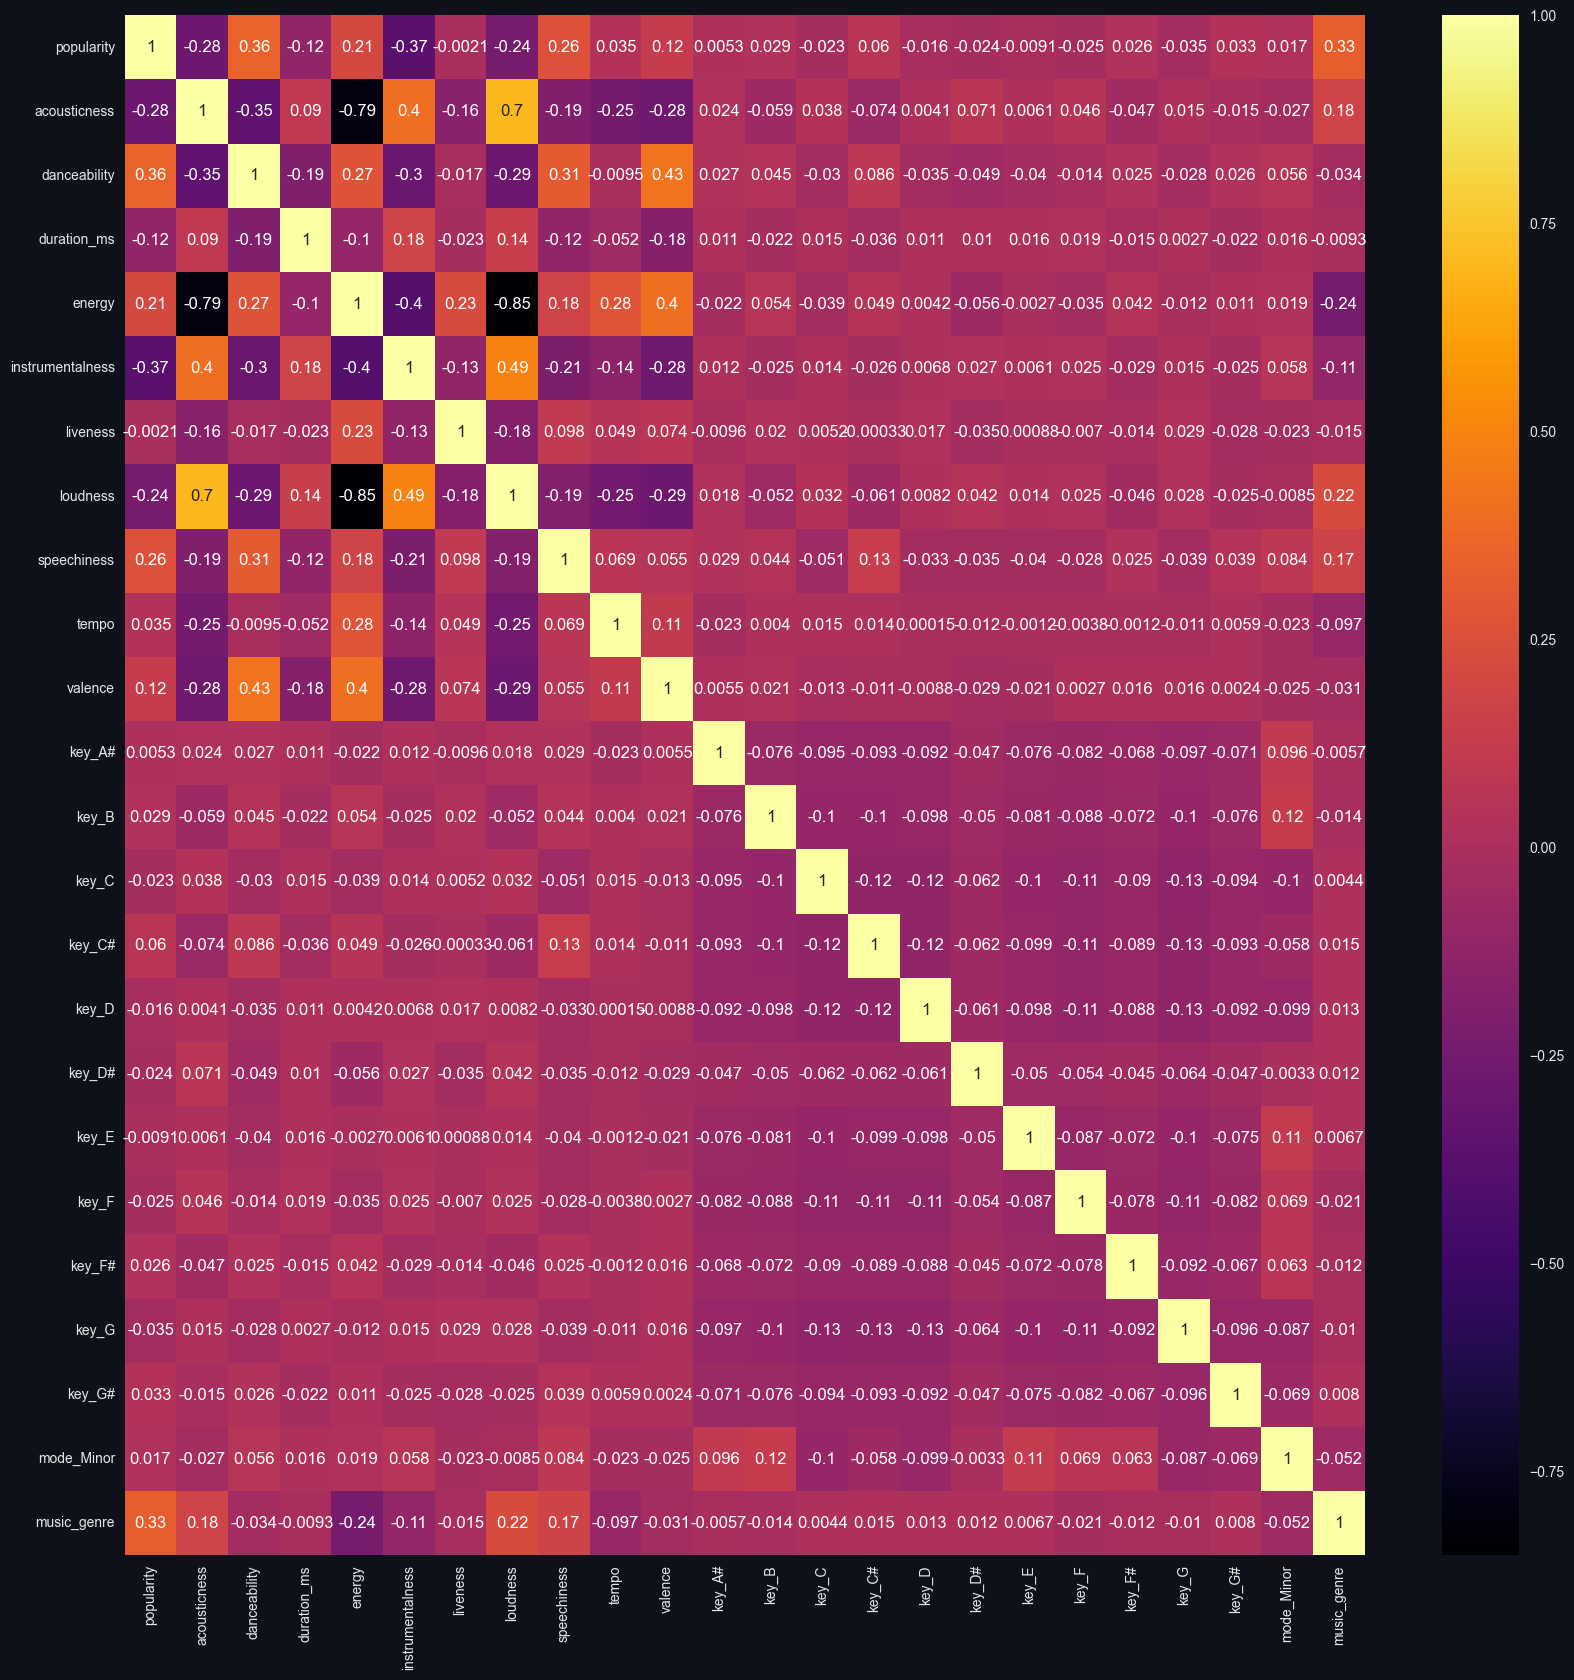

In [15]:
scaledFECorr = checkCorrFF(dfvis, 20, 20)

#### **ANOVA**

We will be using ANOVA to select the best features from the dataset because our dataset is both categorical and numerical.

In [7]:
def anovaSelector(df,k:list=['Default'],verbose:int=0):
    verboseprint = print if verbose==1 else lambda *a, **k: None
    dfa = df.copy()
    if k == ['Default']:
        k = [int(len(dfa.columns)/2)]
    print(f'Start ANOVA feature selection with k={k}')
    # Split the data into X and y
    X = dfa.drop(['music_genre'], axis=1)
    y = dfa['music_genre']
    y_vis = y.replace({'Electronic':0, 'Anime':1, 'Jazz':2, 'Alternative':3, 'Country':4, 'Rap':5, 'Blues':6, 'Rock':7, 'Classical':8, 'Hip-Hop':9})
    # Create Buffer
    bestmodel = {
        "Logistic Regression Model" : None,
        "Decision Tree Model" : None,
        "Random Forest Model" : None,
        "KNN Model" : None,
        "MLPC Model" : None,
    }
    bestresult = {
        "Logistic Regression Model" : 0,
        "Decision Tree Model" : 0,
        "Random Forest Model" : 0,
        "KNN Model" : 0,
        "MLPC Model" : 0,   
    }
    bestK = {
        "Logistic Regression Model" : 0,
        "Decision Tree Model" : 0,
        "Random Forest Model" : 0,
        "KNN Model" : 0,
        "MLPC Model" : 0,
    }
    iteration = 0
    for idx in k:
        verboseprint(f'Number of features: {idx}')
        anova_filter = SelectKBest(f_classif, k=idx)
        anova_filter.fit_transform(X, y)
        anova_support = anova_filter.get_support(indices=True)
        dfanova_select = dfa.iloc[:,anova_support]
        dfanova_select['music_genre'] = y
        verboseprint(f'Features selected: {dfanova_select.columns}')
        verboseprint(f'Star training model...')
        model, result, confmatrix, f1 = modelTestProcess(dfanova_select, getdummy=0,tranform=0)
        for key in bestmodel:
            if f1[key] > bestresult[key]:
                bestmodel[key] = model[key]
                bestresult[key] = f1[key]
                bestK[key] = idx
        iteration += 1
        verboseprint(f'Iteration {iteration} Best K: {bestK}')
        verboseprint('-'*50)
    return bestmodel, bestresult, bestK

In [33]:
'''
Start ANOVA feature selection with k=[8, 9, 10, 11, 12, 13, 14, 15, 16]
Number of features: 8
Features selected: Index(['popularity', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'loudness', 'speechiness', 'valence',
       'music_genre'],
      dtype='object')
Star training model...
Logistic Regression Model (F1 score) : 0.5227237031632449
Decision Tree Model (F1 score) : 0.43392723233412334
Random Forest Model (F1 score) : 0.5398526121142971
KNN Model (F1 score) : 0.4951971868881801
MLPC Model (F1 score) : 0.5826777164013291
Iteration 1 Best K: {'Logistic Regression Model': 8, 'Decision Tree Model': 8, 'Random Forest Model': 8, 'KNN Model': 8, 'MLPC Model': 8}
--------------------------------------------------
Number of features: 9
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'loudness', 'speechiness', 'valence',
       'music_genre'],
      dtype='object')
Star training model...
Logistic Regression Model (F1 score) : 0.5297273878521709
Decision Tree Model (F1 score) : 0.44192720700336197
Random Forest Model (F1 score) : 0.5525403088851218
KNN Model (F1 score) : 0.5074958918239332
MLPC Model (F1 score) : 0.5906099675537292
Iteration 2 Best K: {'Logistic Regression Model': 9, 'Decision Tree Model': 9, 'Random Forest Model': 9, 'KNN Model': 9, 'MLPC Model': 9}
--------------------------------------------------
Number of features: 10
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'loudness', 'speechiness', 'tempo', 'valence',
       'music_genre'],
      dtype='object')
Star training model...
Logistic Regression Model (F1 score) : 0.5297312540851875
Decision Tree Model (F1 score) : 0.446366726121146
Random Forest Model (F1 score) : 0.5579863489861715
KNN Model (F1 score) : 0.5140944966621642
MLPC Model (F1 score) : 0.5859517043992354
Iteration 3 Best K: {'Logistic Regression Model': 10, 'Decision Tree Model': 10, 'Random Forest Model': 10, 'KNN Model': 10, 'MLPC Model': 9}
--------------------------------------------------
Number of features: 11
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'loudness', 'speechiness', 'tempo', 'valence',
       'mode_Minor', 'music_genre'],
      dtype='object')
Star training model...
Logistic Regression Model (F1 score) : 0.5368166247627245
Decision Tree Model (F1 score) : 0.4424139190259887
Random Forest Model (F1 score) : 0.5624468965467975
KNN Model (F1 score) : 0.5149300661725246
MLPC Model (F1 score) : 0.5909779951636618
Iteration 4 Best K: {'Logistic Regression Model': 11, 'Decision Tree Model': 10, 'Random Forest Model': 11, 'KNN Model': 11, 'MLPC Model': 11}
--------------------------------------------------
Number of features: 12
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'mode_Minor', 'music_genre'],
      dtype='object')
Star training model...
Logistic Regression Model (F1 score) : 0.5395554307871461
Decision Tree Model (F1 score) : 0.44477939829525365
Random Forest Model (F1 score) : 0.5603611637420521
KNN Model (F1 score) : 0.5004860053668904
MLPC Model (F1 score) : 0.602901304734554
Iteration 5 Best K: {'Logistic Regression Model': 12, 'Decision Tree Model': 10, 'Random Forest Model': 11, 'KNN Model': 11, 'MLPC Model': 12}
--------------------------------------------------
Number of features: 13
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'key_C#', 'mode_Minor', 'music_genre'],
      dtype='object')
Star training model...
Logistic Regression Model (F1 score) : 0.5404414382374619
Decision Tree Model (F1 score) : 0.44790410411653075
Random Forest Model (F1 score) : 0.5630821209411979
KNN Model (F1 score) : 0.5000854114293107
MLPC Model (F1 score) : 0.5894448864740857
Iteration 6 Best K: {'Logistic Regression Model': 13, 'Decision Tree Model': 13, 'Random Forest Model': 13, 'KNN Model': 11, 'MLPC Model': 12}
--------------------------------------------------
Number of features: 14
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'key_C#', 'key_D#', 'mode_Minor', 'music_genre'],
      dtype='object')
Star training model...
Logistic Regression Model (F1 score) : 0.5403303705374426
Decision Tree Model (F1 score) : 0.4471806497445034
Random Forest Model (F1 score) : 0.5602618411837514
KNN Model (F1 score) : 0.4964662520373163
MLPC Model (F1 score) : 0.6001207744431826
Iteration 7 Best K: {'Logistic Regression Model': 13, 'Decision Tree Model': 13, 'Random Forest Model': 13, 'KNN Model': 11, 'MLPC Model': 12}
--------------------------------------------------
Number of features: 15
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'key_A#', 'key_C#', 'key_D#', 'mode_Minor', 'music_genre'],
      dtype='object')
Star training model...
Logistic Regression Model (F1 score) : 0.5408758154934225
Decision Tree Model (F1 score) : 0.44788436321107206
Random Forest Model (F1 score) : 0.5598881891565288
KNN Model (F1 score) : 0.4908762607162461
MLPC Model (F1 score) : 0.5963033764752333
Iteration 8 Best K: {'Logistic Regression Model': 15, 'Decision Tree Model': 13, 'Random Forest Model': 13, 'KNN Model': 11, 'MLPC Model': 12}
--------------------------------------------------
Number of features: 16
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'key_A#', 'key_C#', 'key_D', 'key_D#', 'mode_Minor',
       'music_genre'],
      dtype='object')
Star training model...
Logistic Regression Model (F1 score) : 0.540789684653497
Decision Tree Model (F1 score) : 0.44873556674861154
Random Forest Model (F1 score) : 0.5574525890615369
KNN Model (F1 score) : 0.4912984248150588
MLPC Model (F1 score) : 0.5901304744338816
Iteration 9 Best K: {'Logistic Regression Model': 15, 'Decision Tree Model': 16, 'Random Forest Model': 13, 'KNN Model': 11, 'MLPC Model': 12}
--------------------------------------------------

'''
# anovamodelSS, anovaresultSS, anovaKSS = anovaSelector(dfSS,k = [8,9,10,11,12,13,14,15,16],verbose=1)
pass

In [32]:
'''
Start ANOVA feature selection with k=[8, 9, 10, 11, 12, 13, 14, 15, 16]
Number of features: 8
Features selected: Index(['popularity', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'loudness', 'speechiness', 'valence',
       'music_genre'],
      dtype='object')
Star training model...
Logistic Regression Model (F1 score) : 0.5230053050686406
Decision Tree Model (F1 score) : 0.43411568590165317
Random Forest Model (F1 score) : 0.5362054115173611
KNN Model (F1 score) : 0.4993425595311983
MLPC Model (F1 score) : 0.5851012909274124
Iteration 1 Best K: {'Logistic Regression Model': 8, 'Decision Tree Model': 8, 'Random Forest Model': 8, 'KNN Model': 8, 'MLPC Model': 8}
--------------------------------------------------
Number of features: 9
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'loudness', 'speechiness', 'valence',
       'music_genre'],
      dtype='object')
Star training model...
Logistic Regression Model (F1 score) : 0.5293303806163776
Decision Tree Model (F1 score) : 0.44348851849517135
Random Forest Model (F1 score) : 0.552673975914363
KNN Model (F1 score) : 0.504402920406828
MLPC Model (F1 score) : 0.5907946392797983
Iteration 2 Best K: {'Logistic Regression Model': 9, 'Decision Tree Model': 9, 'Random Forest Model': 9, 'KNN Model': 9, 'MLPC Model': 9}
--------------------------------------------------
Number of features: 10
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'loudness', 'speechiness', 'tempo', 'valence',
       'music_genre'],
      dtype='object')
Star training model...
Logistic Regression Model (F1 score) : 0.5296285510296003
Decision Tree Model (F1 score) : 0.44873811444365735
Random Forest Model (F1 score) : 0.5550084056914361
KNN Model (F1 score) : 0.5058644840521187
MLPC Model (F1 score) : 0.5891689013814947
Iteration 3 Best K: {'Logistic Regression Model': 10, 'Decision Tree Model': 10, 'Random Forest Model': 10, 'KNN Model': 10, 'MLPC Model': 9}
--------------------------------------------------
Number of features: 11
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'loudness', 'speechiness', 'tempo', 'valence',
       'mode_Minor', 'music_genre'],
      dtype='object')
Star training model...
Logistic Regression Model (F1 score) : 0.5370195686630351
Decision Tree Model (F1 score) : 0.44757916126223474
Random Forest Model (F1 score) : 0.5616059240879082
KNN Model (F1 score) : 0.5052100895135229
MLPC Model (F1 score) : 0.5886125555735734
Iteration 4 Best K: {'Logistic Regression Model': 11, 'Decision Tree Model': 10, 'Random Forest Model': 11, 'KNN Model': 10, 'MLPC Model': 9}
--------------------------------------------------
Number of features: 12
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'mode_Minor', 'music_genre'],
      dtype='object')
Star training model...
Logistic Regression Model (F1 score) : 0.5390950654528935
Decision Tree Model (F1 score) : 0.44486716044030417
Random Forest Model (F1 score) : 0.5580967298476013
KNN Model (F1 score) : 0.4908427897142021
MLPC Model (F1 score) : 0.6021549363189792
Iteration 5 Best K: {'Logistic Regression Model': 12, 'Decision Tree Model': 10, 'Random Forest Model': 11, 'KNN Model': 10, 'MLPC Model': 12}
--------------------------------------------------
Number of features: 13
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'key_C#', 'mode_Minor', 'music_genre'],
      dtype='object')
Star training model...
Logistic Regression Model (F1 score) : 0.5402195474485278
Decision Tree Model (F1 score) : 0.442352233436013
Random Forest Model (F1 score) : 0.563232314387615
KNN Model (F1 score) : 0.4907745058531065
MLPC Model (F1 score) : 0.5929460211873627
Iteration 6 Best K: {'Logistic Regression Model': 13, 'Decision Tree Model': 10, 'Random Forest Model': 13, 'KNN Model': 10, 'MLPC Model': 12}
--------------------------------------------------
Number of features: 14
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'key_C#', 'key_D#', 'mode_Minor', 'music_genre'],
      dtype='object')
Star training model...
Logistic Regression Model (F1 score) : 0.5401314217324025
Decision Tree Model (F1 score) : 0.4408979826485338
Random Forest Model (F1 score) : 0.5592613843659694
KNN Model (F1 score) : 0.49195211023511626
MLPC Model (F1 score) : 0.6042552207891586
Iteration 7 Best K: {'Logistic Regression Model': 13, 'Decision Tree Model': 10, 'Random Forest Model': 13, 'KNN Model': 10, 'MLPC Model': 14}
--------------------------------------------------
Number of features: 15
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'key_A#', 'key_C#', 'key_D#', 'mode_Minor', 'music_genre'],
      dtype='object')
Star training model...
Logistic Regression Model (F1 score) : 0.5408905204659693
Decision Tree Model (F1 score) : 0.446231301481206
Random Forest Model (F1 score) : 0.5612048805463546
KNN Model (F1 score) : 0.4910809317027264
MLPC Model (F1 score) : 0.5962027138682453
Iteration 8 Best K: {'Logistic Regression Model': 15, 'Decision Tree Model': 10, 'Random Forest Model': 13, 'KNN Model': 10, 'MLPC Model': 14}
--------------------------------------------------
Number of features: 16
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'key_A#', 'key_C#', 'key_D', 'key_D#', 'mode_Minor',
       'music_genre'],
      dtype='object')
Star training model...
Logistic Regression Model (F1 score) : 0.5408699968863111
Decision Tree Model (F1 score) : 0.4462829488675167
Random Forest Model (F1 score) : 0.5632327896756598
KNN Model (F1 score) : 0.49133212232225687
MLPC Model (F1 score) : 0.5936959589730711
Iteration 9 Best K: {'Logistic Regression Model': 15, 'Decision Tree Model': 10, 'Random Forest Model': 16, 'KNN Model': 10, 'MLPC Model': 14}
--------------------------------------------------

'''
# anovamodelRB, anovaresultRB, anovaKRB = anovaSelector(dfRB,k = [8,9,10,11,12,13,14,15,16],verbose=1)
pass

เนื่องจากคะแนนที่ได้จากการทำ Benchmark ด้วย ANOVA ที่เลือก Feature ที่มีค่าค่อนข้างสูงที่ K = 11 โดยหากมากกว่านั้นจะมีบาง Model ที่มีคะแนนเพิ่มมากขึ้น แต่เพิ่มขึ้นค่อนข้างน้อยมากดังนั้นแล้วเราจะเลือก K = 11 เพื่อให้ Model ที่ได้มีความแม่นและลด Overfitting ของ Model ลง (เนื่องจากจำนวน Feature ที่เหลือน้อยลง)

In [72]:
#Logistic Regression Model#
selectorSS13 = SelectKBest(f_classif, k=13)
XSSselect13 = selectorSS13.fit(Xss, y)
col = XSSselect13.get_support(indices=True)
dfSSSelect13 = dfSS.iloc[:,col]
dfSSSelect13['music_genre'] = y
#Decision Tree Model#
selectorRB10 = SelectKBest(f_classif, k=10)
XselectRB10 = selectorRB10.fit(Xrb, y)
col = XselectRB10.get_support(indices=True)
dfRBSelect10 = dfRB.iloc[:,col]
dfRBSelect10['music_genre'] = y
#Random Forest Model#
selectorRB13 = SelectKBest(f_classif, k=13)
XselectRB13 = selectorRB13.fit(Xrb, y)
col = XselectRB13.get_support(indices=True)
dfRBSelect13 = dfRB.iloc[:,col]
dfRBSelect13['music_genre'] = y
#KNN Model#
selectorSS11 = SelectKBest(f_classif, k=11)
XSSselect11 = selectorSS11.fit(Xss, y)
col = XSSselect11.get_support(indices=True)
dfSSelect11 = dfSS.iloc[:,col]
dfSSelect11['music_genre'] = y
#MLPC Model#
selectorRB14 = SelectKBest(f_classif, k=14)
XselectRB14 = selectorRB14.fit(Xrb, y)
col = XselectRB14.get_support(indices=True) 
dfRBSelect14 = dfRB.iloc[:,col]
dfRBSelect14['music_genre'] = y
#Grouping the dataframes#
dfSelectDict = {'Logistic Regression Model':dfSSSelect13,
                'Decision Tree Model':dfRBSelect10,
                'Random Forest Model':dfRBSelect13,
                'KNN Model':dfSSelect11,
                'MLPC Model':dfRBSelect14}

โดย Feature ที่ถูกตัดออกจาก Dataset จะมีข้อสังเกตดังนี้ดังนี้

In [24]:
df = pd.read_csv('Data/dfOutlier_res.csv')
Xcat = pd.get_dummies(df.drop(['music_genre'],axis=1),drop_first=True)
Xcat = Xcat[['key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#',
       'key_E', 'key_F', 'key_F#', 'key_G', 'key_G#', 'mode_Minor',]]
Xcat

,key_A#,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Minor
0,1,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
47587,0,0,0,1,0,0,0,0,0,0,0,0
47588,0,1,0,0,0,0,0,0,0,0,0,0
47589,0,0,0,0,1,0,0,0,0,0,0,0
47590,0,0,0,0,0,0,0,0,0,1,0,1


In [25]:
dfXCat = pd.concat([Xcat,df['music_genre']],axis=1)
dfCateDict = {"Electronic": dfXCat.groupby('music_genre').get_group('Hip-Hop'),
            "Anime": dfXCat.groupby('music_genre').get_group('Anime'),
            "Jazz": dfXCat.groupby('music_genre').get_group('Jazz'),
            "Alternative": dfXCat.groupby('music_genre').get_group('Alternative'),
            "Country": dfXCat.groupby('music_genre').get_group('Country'),
            "Rap": dfXCat.groupby('music_genre').get_group('Rap'),
            "Blues": dfXCat.groupby('music_genre').get_group('Blues'),
            "Rock": dfXCat.groupby('music_genre').get_group('Rock'),
            "Classical": dfXCat.groupby('music_genre').get_group('Classical'),
            "Hip-Hop": dfXCat.groupby('music_genre').get_group('Hip-Hop'),
}

In [30]:
catcol = ['key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#',]
catVisPlot , axes = plt.subplots( len(catcol),10, figsize=(40, 30))
count = 0
for key, item in dfCateDict.items():
    for idx,col in enumerate(catcol):
        ax = axes[idx,count]
        sns.countplot(x=col, data=item, ax=ax)
        ax.set_title(f'{key} Groups', weight='bold', fontsize=10)
    count += 1

In [31]:
catcol = ['key_E', 'key_F', 'key_F#', 'key_G', 'key_G#', 'mode_Minor',]
catVisPlot , axes = plt.subplots( len(catcol),10, figsize=(40, 30))
count = 0
for key, item in dfCateDict.items():
    for idx,col in enumerate(catcol):
        ax = axes[idx,count]
        sns.countplot(x=col, data=item, ax=ax)
        ax.set_title(f'{key} Groups', weight='bold', fontsize=10)
    count += 1

In [28]:
selectorChi2 = SelectKBest(chi2, k=3)
XcatSelected = selectorChi2.fit_transform(Xcat, df['music_genre'])
colcat = selectorChi2.get_support(indices=True)
Xcat = Xcat.iloc[:,colcat]
catcol = Xcat.columns
Xcat['music_genre'] = df['music_genre']
Xcat

,key_C#,key_D#,mode_Minor,music_genre
0,0,0,1,Electronic
1,0,0,1,Electronic
2,0,0,0,Electronic
3,1,0,0,Electronic
4,0,0,0,Electronic
...,...,...,...,...
47587,1,0,0,Hip-Hop
47588,0,0,0,Hip-Hop
47589,0,0,0,Hip-Hop
47590,0,0,1,Hip-Hop


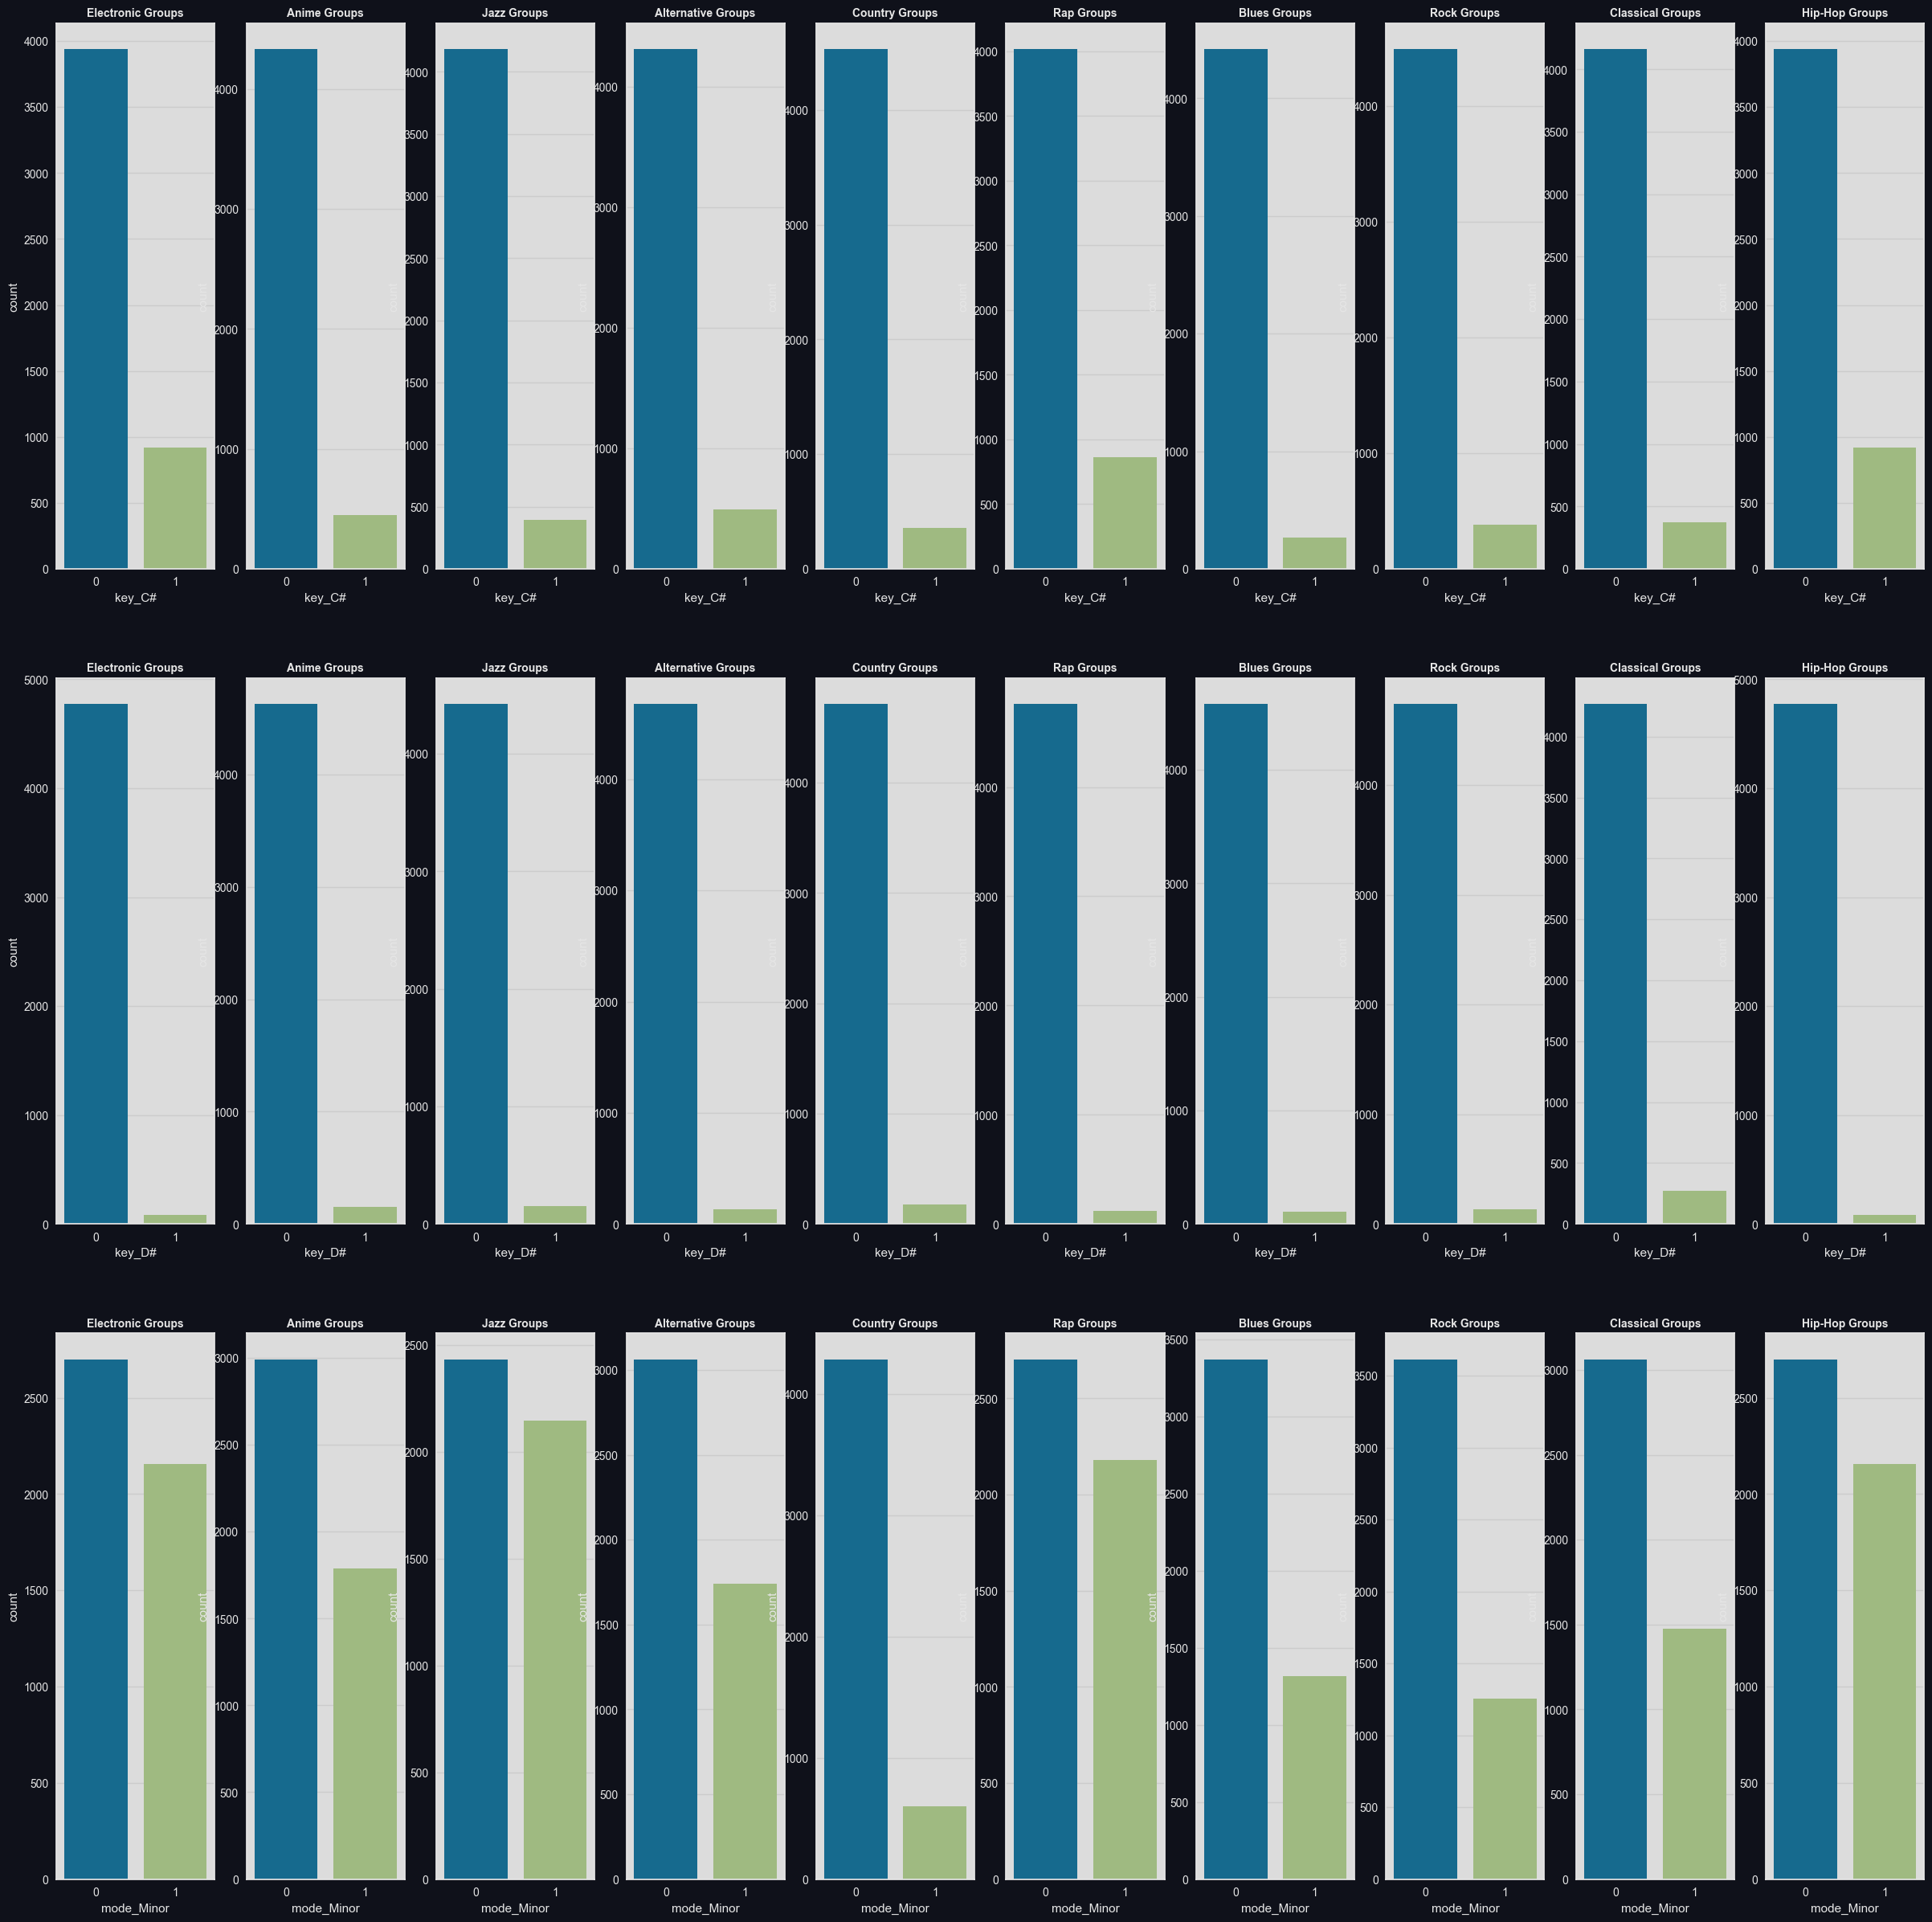

In [29]:
dfCateDict = {"Electronic": Xcat.groupby('music_genre').get_group('Hip-Hop'),
            "Anime": Xcat.groupby('music_genre').get_group('Anime'),
            "Jazz": Xcat.groupby('music_genre').get_group('Jazz'),
            "Alternative": Xcat.groupby('music_genre').get_group('Alternative'),
            "Country": Xcat.groupby('music_genre').get_group('Country'),
            "Rap": Xcat.groupby('music_genre').get_group('Rap'),
            "Blues": Xcat.groupby('music_genre').get_group('Blues'),
            "Rock": Xcat.groupby('music_genre').get_group('Rock'),
            "Classical": Xcat.groupby('music_genre').get_group('Classical'),
            "Hip-Hop": Xcat.groupby('music_genre').get_group('Hip-Hop'),
}
catVisPlot , axes = plt.subplots( len(catcol), 10, figsize=(30, 30))
count = 0
for key, item in dfCateDict.items():
    for idx,col in enumerate(catcol):
        ax = axes[idx,count]
        sns.countplot(x=col, data=item, ax=ax)
        ax.set_title(f'{key} Groups', weight='bold', fontsize=10)
    count += 1

##### **Performance**

In [81]:
def modelTestProcessFE(dfdict ,verbose=0):
    verboseprint = print if verbose==1 else lambda *a, **k: None
    # Model
    LR_clf = LogisticRegression(n_jobs=-1, random_state=1,multi_class='multinomial')
    DT_clf = DecisionTreeClassifier(random_state=1)
    RF_clf = RandomForestClassifier(n_jobs=-1, random_state=1)
    KNN_clf = KNeighborsClassifier(n_jobs=-1)
    MLPC_clf = MLPClassifier(random_state=1)
    # SVC_clf = LinearSVC(random_state=1,multi_class='crammer_singer') # U take too much time
    modeldict = {'Logistic Regression Model':LR_clf, 'Decision Tree Model':DT_clf, 'Random Forest Model':RF_clf,
                'KNN Model':KNN_clf, 'MLPC Model':MLPC_clf}
    # Training
    traintestdict = {}
    for modelname, model in modeldict.items():
        X = dfdict[modelname].drop(['music_genre'],axis=1)
        y = dfdict[modelname]['music_genre']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
        traintestdict[modelname] = [X_train, X_test, y_train, y_test]
        model.fit(X_train, y_train)
        verboseprint(f'{modelname} trained.')
        verboseprint(f'-'*50)
    # Testing
    resultdict = {}
    confusion_matrix_dict = {}
    f1scoredict = {}
    for modelname, model in modeldict.items():
        X_train, X_test, y_train, y_test = traintestdict[modelname]
        y_pred = model.predict(X_test)
        resultdict[modelname] = classification_report(y_test, y_pred)
        confusion_matrix_dict[modelname] = confusion_matrix(y_test, y_pred)
        f1scoredict[modelname] = f1_score(y_test, y_pred, average='weighted')
    for key, value in f1scoredict.items():
        print(f'{key} (F1 score) : {value}')
    return modeldict,resultdict,confusion_matrix_dict,f1scoredict

In [84]:
modelBM_Select, resultBM_Select, confmatrixBM_Select, f1BM_Select = modelTestProcessFE(dfSelectDict,verbose=0)

Logistic Regression Model (F1 score) : 0.5404414382374619
Decision Tree Model (F1 score) : 0.44873811444365735
Random Forest Model (F1 score) : 0.563232314387615
KNN Model (F1 score) : 0.5149300661725246
MLPC Model (F1 score) : 0.6042552207891586


#### **Feature Drop Experiment**

In [78]:
dfSelectDictD = {}
for dfname, df in dfSelectDict.items():
    dfdrop = df.copy()
    dfSelectDictD[dfname] = dfdrop.drop(['loudness','energy'], axis=1)

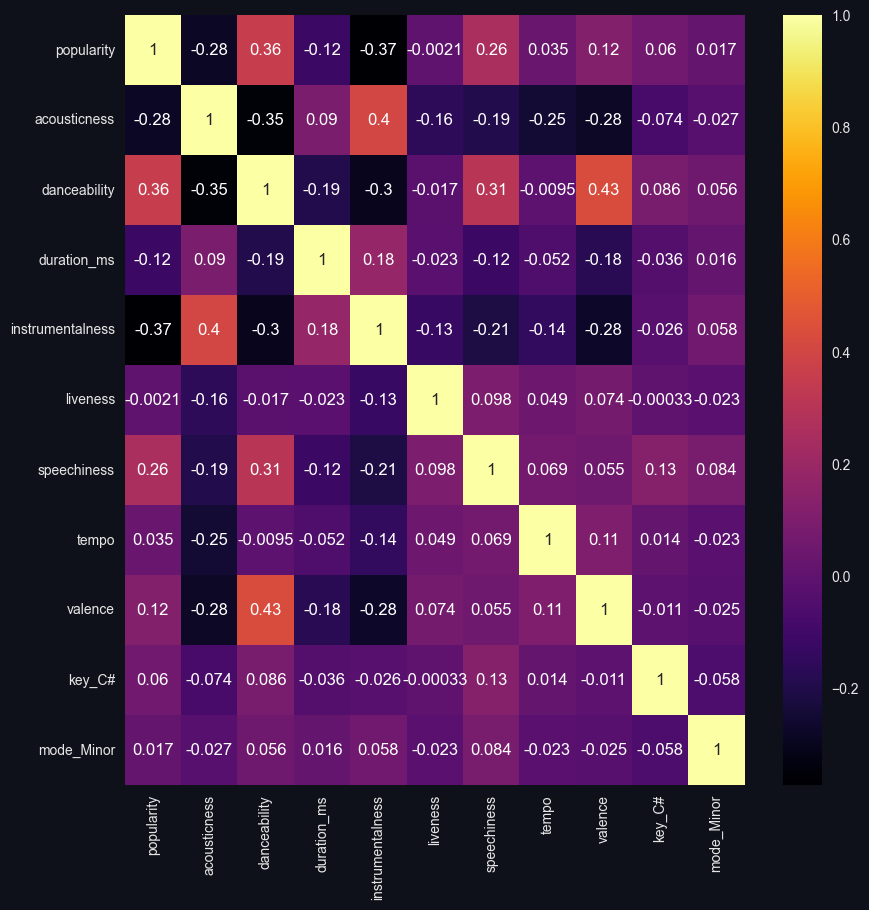

In [79]:
SelectD = checkCorrFF(dfSelectDictD['Logistic Regression Model'], 10, 10)

##### **Performance**

In [85]:
modelBM_SelectD, resultBM_SelectD, confmatrixBM_SelectD, f1BM_SelectD = modelTestProcessFE(dfSelectDictD,verbose=0)

Logistic Regression Model (F1 score) : 0.5188305921941005
Decision Tree Model (F1 score) : 0.43479316606142143
Random Forest Model (F1 score) : 0.5494576700998701
KNN Model (F1 score) : 0.4938897754122692
MLPC Model (F1 score) : 0.5852795975636297


#### **Principal Component Analysis (PCA)**

In [86]:
def dfPCAGenerator(df, threshold,verbose:int=0):
    verboseprint = print if verbose==1 else lambda *a, **k: None
    dfPCA = df.copy()
    pca = PCA(n_components = len(dfPCA.columns))           
    pca.fit_transform(dfPCA)          

    # Print the explained variance ratio
    verboseprint('Number of components: ', pca.n_components_)
    verboseprint(f'Variace list: {pca.explained_variance_ratio_}')
    for i in range(len(pca.explained_variance_ratio_)):
        verboseprint('PC', i+1, ': ', np.around(pca.explained_variance_ratio_[i],4), ' (', np.around(sum(pca.explained_variance_ratio_[0:i+1]),4), ')')
    
    # Select the number of components where the variance is above the threshold
    varThreshold = threshold
    var = np.where(pca.explained_variance_ratio_.cumsum() >= varThreshold)[0][0] +1
    realVar = pca.explained_variance_ratio_.cumsum()[var-1]
    print(f'Number of components to explain {realVar*100}% of variance: {var}')
    
    # Plot the explained variance ratio
    if verbose == 1:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        for i in range(0, len(pca.explained_variance_ratio_)):
            ax.plot(i+1, pca.explained_variance_ratio_[i], 'ro')
    else :
        fig = None
    
    # Apply PCA to the dataset
    dfPCA = df.copy()
    pca = PCA(n_components = var)
    x_pca = pca.fit_transform(dfPCA)
    col = [
        str(f'PC{i+1}') for i in range(0, len(pca.explained_variance_ratio_))
        ]

    dfPCA = pd.DataFrame(x_pca, columns = col)
    return dfPCA, fig

In [87]:
def pcaSelector(df,threshold:list=['Default'],verbose:int=0):
    verboseprint = print if verbose==1 else lambda *a, **k: None
    dfp = df.copy()
    if threshold == ['Default']:
        threshold = [0.9]
    print(f'Start PCA feature selection with threshold={threshold}')
    # Split the data into X and y
    X = dfp.drop(['music_genre'], axis=1)
    y = dfp['music_genre']
    y_vis = y.replace({'Electronic':0, 'Anime':1, 'Jazz':2, 'Alternative':3, 'Country':4, 'Rap':5, 'Blues':6, 'Rock':7, 'Classical':8, 'Hip-Hop':9})
    # Create Buffer
    bestmodel = {
        "Logistic Regression Model" : None,
        "Decision Tree Model" : None,
        "Random Forest Model" : None,
        "KNN Model" : None,
        "MLPC Model" : None,
    }
    bestresult = {
        "Logistic Regression Model" : 0,
        "Decision Tree Model" : 0,
        "Random Forest Model" : 0,
        "KNN Model" : 0,
        "MLPC Model" : 0,   
    }
    bestthreshold = {
        "Logistic Regression Model" : 0,
        "Decision Tree Model" : 0,
        "Random Forest Model" : 0,
        "KNN Model" : 0,
        "MLPC Model" : 0,   
    }
    for idx in threshold:
        verboseprint(f'Threshold: {idx}')
        dfPCA, fig = dfPCAGenerator(X, idx, verbose)
        dfPCA['music_genre'] = y
        verboseprint(f'Star training model...')
        model, result, confmatrix, f1 = modelTestProcess(dfPCA, getdummy=0, verbose = verbose)
        for key in bestmodel:
            if f1[key] > bestresult[key]:
                bestmodel[key] = model[key]
                bestresult[key] = f1[key]
                bestthreshold[key] = idx
        print(f'Best Threshold: {bestthreshold}')
        print('-'*50)
    return bestmodel, bestresult, bestthreshold

In [ ]:
dfSelectPCA = dfSelect.copy()
dfSelectDPCA = dfSelectD.copy()
Xpca, ypca = dfSelectPCA.drop(['music_genre'], axis=1), dfSelectPCA['music_genre']
Xdpca, ydpca = dfSelectDPCA.drop(['music_genre'], axis=1), dfSelectDPCA['music_genre']

<hr>

##### **PCA For ANOVA data**

In [ ]:
pca = PCA(n_components = len(Xpca.columns))           
pca.fit_transform(Xpca)          

# Print the explained variance ratio
print('Number of components: ', pca.n_components_)
print(f'Variace list: {pca.explained_variance_ratio_}')
for i in range(len(pca.explained_variance_ratio_)):
    print('PC', i+1, ': ', np.around(pca.explained_variance_ratio_[i],4), ' (', np.around(sum(pca.explained_variance_ratio_[0:i+1]),4), ')')

In [ ]:
"""
Start PCA feature selection with threshold=[0.8, 0.85, 0.9, 0.95]
Number of components to explain 80.49220840733858% of variance: 6
Logistic Regression Model (F1 score) : 0.4127771498037407
Decision Tree Model (F1 score) : 0.3592784218585783
Random Forest Model (F1 score) : 0.4603479745291564
KNN Model (F1 score) : 0.43789196539073055
MLPC Model (F1 score) : 0.5162572645841518
Best Threshold: {'Logistic Regression Model': 0.8, 'Decision Tree Model': 0.8, 'Random Forest Model': 0.8, 'KNN Model': 0.8, 'MLPC Model': 0.8}
--------------------------------------------------
Number of components to explain 87.03959061702754% of variance: 7
Logistic Regression Model (F1 score) : 0.46788931410341694
Decision Tree Model (F1 score) : 0.3733342166087479
Random Forest Model (F1 score) : 0.4877676756125047
KNN Model (F1 score) : 0.4642210045335403
MLPC Model (F1 score) : 0.5375235707609866
Best Threshold: {'Logistic Regression Model': 0.85, 'Decision Tree Model': 0.85, 'Random Forest Model': 0.85, 'KNN Model': 0.85, 'MLPC Model': 0.85}
--------------------------------------------------
Number of components to explain 92.5113522229171% of variance: 8
Logistic Regression Model (F1 score) : 0.4929173972990741
Decision Tree Model (F1 score) : 0.39188068545877963
Random Forest Model (F1 score) : 0.49700398298983284
KNN Model (F1 score) : 0.4798074053741314
MLPC Model (F1 score) : 0.5560387893103839
Best Threshold: {'Logistic Regression Model': 0.9, 'Decision Tree Model': 0.9, 'Random Forest Model': 0.9, 'KNN Model': 0.9, 'MLPC Model': 0.9}
--------------------------------------------------
Number of components to explain 96.73700647477908% of variance: 9
Logistic Regression Model (F1 score) : 0.5217498077763344
Decision Tree Model (F1 score) : 0.4113205866609827
Random Forest Model (F1 score) : 0.5219472104713351
KNN Model (F1 score) : 0.4926607240980474
MLPC Model (F1 score) : 0.5890020475391913
Best Threshold: {'Logistic Regression Model': 0.95, 'Decision Tree Model': 0.95, 'Random Forest Model': 0.95, 'KNN Model': 0.95, 'MLPC Model': 0.95}
--------------------------------------------------
"""

# bestmodelPCA, bestresultPCA, bestthresholdPCA = pcaSelector(dfSelectPCA,threshold=[0.80,0.85,0.90,0.95],verbose=0)

In [ ]:
dfPCA, fig = dfPCAGenerator(Xpca, 0.95)
dfPCA['music_genre'] = ypca
pcaSummary_df = pd.DataFrame({'Standard deviation': np.sqrt(pca.explained_variance_),
                           'Proportion of variance': pca.explained_variance_ratio_,
                           'Cumulative proportion': np.cumsum(pca.explained_variance_ratio_),
                             'Variance Explanation Ratio': pca.explained_variance_ratio_,
                             'Cumulative Ratio' : np.cumsum(pca.explained_variance_ratio_) })

pcaSummary_df = pcaSummary_df.transpose()
pcaSummary_df.columns = ['PC{}'.format(i) for i in range(1, len(Xpca.columns) + 1)]
pcaSummary_df.round(4)

In [ ]:
modelPCA, resultPCA, confmatrixPCA, f1PCA = modelTestProcess(dfPCA, getdummy=0, verbose = 0)

<hr>

##### **PCA For Feature Drop Experiment**

In [ ]:
pcad = PCA(n_components = len(Xdpca.columns))           
pcad.fit_transform(Xdpca)          

# Print the explained variance ratio
print('Number of components: ', pcad.n_components_)
print(f'Variace list: {pcad.explained_variance_ratio_}')
for i in range(len(pcad.explained_variance_ratio_)):
    print('PC', i+1, ': ', np.around(pcad.explained_variance_ratio_[i],4), ' (', np.around(sum(pcad.explained_variance_ratio_[0:i+1]),4), ')')

In [ ]:
dfPCAd, fig = dfPCAGenerator(Xdpca, 0.89)
dfPCAd['music_genre'] = ydpca
pcadSummary_df = pd.DataFrame({'Standard deviation': np.sqrt(pcad.explained_variance_),
                           'Proportion of variance': pcad.explained_variance_ratio_,
                           'Cumulative proportion': np.cumsum(pcad.explained_variance_ratio_),
                             'Variance Explanation Ratio': pcad.explained_variance_ratio_,
                             'Cumulative Ratio' : np.cumsum(pcad.explained_variance_ratio_) })

pcadSummary_df = pcadSummary_df.transpose()
pcadSummary_df.columns = ['PC{}'.format(i) for i in range(1, len(Xdpca.columns) + 1)]
pcadSummary_df.round(4)

In [ ]:
modelPCAd , resultPCAd, confmatrixPCAd, f1PCAd = modelTestProcess(dfPCAd, getdummy=0, verbose = 0)

#### **Conclusion**

In [ ]:
# ANOVA (11 features)
dfSelect.to_csv('Data/dfSelect.csv', index=False)
dfSelectPCA.to_csv('Data/dfSelectPCA.csv', index=False)
# Drop High Correlation (9 features)
dfSelectD.to_csv('Data/dfSelectD.csv', index=False)
dfSelectDPCA.to_csv('Data/dfSelectDPCA.csv', index=False)